# Calibrating the Brighter-Fatter Effect (BFE) using `amigo`.

This small tutorial is designed to show users how to interact with the `amigo` package, and generally fit it to data. We will look at the training of the 'reference model', a large model trained on many different data sets to try and calibrate both the linear and non-linear detector effect, primarily the BFE.

Lets start with some basic plotting configuration.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

The `amigo.files` module contains many functions for reading, processing and initialising objects from the standard fits files. Note that processing the uncalibrated data into a format that will work with `amigo` is covered by the 'data_processing.ipynb' notebook. 

There two main functions to loading and examining the fits files, `get_files` and `summarise_files``

`get_files`: Takes in a directory or list of directories, a filetype, and header keywords. It will find all the files in the directory that match the filetype and have the header keywords. It will then return a list of the files. Here we use a `lambda` function to bind the directory, filetype and filter to a function, so that we can load each star _individually_ to make it easier to know what data we are looking at.

`summarise_files`: Takes in a list of files, and a list of header keywords. It will then print out the set of those keywords for each file. This is useful for checking that the files have been loaded correctly, and that the header keywords are correct.

In [2]:
from amigo.files import get_files, summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/ERS1386/calgrps/",
        "/Users/louis/Data/JWST/amigo_data/COMM1903/calgrps/",
    ],
    "calgrps",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs,
)


# Get each star
HD37803_files = file_fn(TARGPROP="HD-37093")  # COMM data
HD36805_files = file_fn(TARGPROP="HD-36805")  # COMM data
HD116084_files = file_fn(TARGPROP="HD-116084")  # ERS data
HD115842_files = file_fn(TARGPROP="HD-115842")  # ERS data

# Build data set
files = HD37803_files[:2] + HD36805_files[:2] + HD116084_files[:2] + HD115842_files[:2]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN"],
)

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision

8
  TARGPROP: HD-36805, HD-37093, HD-115842, HD-116084
  FILTER: F480M, F380M
  NINTS: 65, 10000, 6000, 118, 5500, 61
  NGROUPS: 2, 3, 4, 9, 12
  OBSERVTN: 010, 020, 017, 012, 018, 016


## Building the model

Now we need to build the model we will use to fit the data. This model is unique in the landscape of physical models since we are both fitting global parameters to all the data sets (such as the aperture mask and BFE), while also fitting parameters to each _individual_ data set. `amigo` has a lot a functions to make initialising these models simple. In short, we need an optical system, a detector, a BFE model, plus filters and effective temperatures for each star. The code below should initialise all this automatically for you, but you can always tweak the values if you want.

Note that this can take a while to run, since it checks MAST to load the closest WSS data for each exposure, as well as searches the Gaia + Simbad databases to try and find the effective temperature for each star. Since it is interfacing with databases, runtime can vary.

In [3]:
from amigo.core import SUB80Ramp, BaseModeller, AMIOptics
from amigo.BFE import PolyBFE
from amigo.files import (
    get_Teffs,
    get_filters,
    get_exposures,
    initialise_params,
)


# Get dLux optical system
optics = AMIOptics()
detector = SUB80Ramp()
BFE = PolyBFE(ksize=5, oversample=1, orders=[1, 2])

# Prep the model
exposures = get_exposures(files)
params = initialise_params(exposures)
params["Teffs"] = get_Teffs(files)
params["filters"] = get_filters(files)
params["optics"] = optics
params["detector"] = detector
params["BFE"] = BFE

model = BaseModeller(params)

Now we define out modelling function. This simply takes in the 'big model' we created in the above cell and an exposure and generates a ramp fit to the data. In future this will probably be hidden in the `amigo` package, but since users may want to add custom behaviour (ie resolved sources) we define it explicitly here.

In [4]:
import equinox as eqx
import dLux.utils as dlu
from jax import vmap
from amigo.misc import planck
from amigo.stats import total_read_noise
from amigo.detector_layers import model_ramp


def model_fn(model, exposure, to_BFE=False):
    # Get exposure key
    key = exposure.key

    # Get wavelengths and weights
    wavels, filt_weights = model.filters[exposure.filter]
    weights = filt_weights * planck(wavels, model.Teffs[exposure.star])
    weights *= model.fluxes[key] / weights.sum()

    # Apply correct aberrations
    optics = model.optics.set(
        ["coefficients", "pupil.opd"],
        [model.aberrations[key], exposure.opd],
    )

    # Make sure this has correct position units and get wavefronts
    pos_rad = dlu.arcsec2rad(model.positions[key])
    PSF = optics.propagate(wavels, pos_rad, weights, return_psf=True)

    # Apply the detector model and turn it into a ramp
    psf = model.detector.model(PSF)
    ramp = model_ramp(psf, exposure.ngroups)
    if to_BFE:
        return ramp

    # Now apply the CNN BFE and downsample
    ramp = eqx.filter_vmap(model.BFE.apply_array)(ramp)
    ramp = vmap(dlu.resize, (0, None))(ramp, 80)

    # Apply bias and one of F correction
    ramp += total_read_noise(model.biases[key], model.OneOnFs[key])
    return ramp

## Likelihood and Loss functions

Here we define the posterior of our model and our loss function. As with the above cell, this will likely be hidden into `amigo` down the line, but for now we define it explicitly to be clear about what we are doing, and to allow for custom behaviour.

In [5]:
import jax.numpy as np
import jax.scipy as jsp


def log_prior(model, exposure, mean=80, std=50):
    # Estimated std is ~25, so we use 50 here to be conservative
    # Estimated mean is taken from the initial bias estimation
    bias_vec = model.biases[exposure.key][*exposure.support]
    return jsp.stats.norm.logpdf(bias_vec, loc=mean, scale=std).sum()


def posterior(model, exposure, per_pix=True):
    ramp = model_fn(model, exposure)
    loglike = exposure.loglike_vec(ramp).sum()
    posterior = loglike + log_prior(model, exposure).sum()
    if per_pix:
        return posterior / np.prod(np.array(exposure.data.shape[-2:]))
    return posterior


def loss_fn(model, exposures):
    return -np.array([posterior(model, exp) for exp in exposures]).sum()

## Normalisation and gradient processing

Here we define two functions, the `norm_fn` and `grad_fn`. 

The normalisation function is used to ensure that values stay within correct bounds during optimisation. For example we might want the mean Subpixel Response Function (SRF) to have a mean sensitivity of 1 to avoid heavy covariance with flux, as is implemented below. This norm function is applied _after_ the update step, so this does not affect the loss or gradients.

The `grad_fn` is used to normalise the gradients across the model. This is very important since without it we would need to tweak _every learning rate for every parameter for every possible combination of input data_, which is obviously not practical. There are two normalisations that are applied here, _global_ and _per exposure_. Since the gradients from _every_ data set are added to the global parameters we need to normalise them by the total number of images (ie ngroups * nitnts for every exposure). On the contrary we need to normalise the gradients for the per exposure parameters by the number of images in _that_ exposure. This allows for a single learning rate to work _all_ data sets which is very important for the optimisation to work.

In [6]:
import jax.tree_util as jtu

def norm_fn(model, args):
    return model.multiply("sensitivity.SRF", 1 / model.sensitivity.SRF.mean())


def grad_fn(grads, args, config):
    exposures = args
    global_params = [
        "BFE.linear",
        "BFE.quadratic",
        "sensitivity.SRF",
        "pupil_mask.holes",
        "pupil_mask.f2f",
        "rotation",
        "shear",
        "compression",
    ]
    nims = np.array([exp.nints * exp.ngroups for exp in exposures]).sum()

    # Global parameters need to be normalised by the total number of integrations
    params_in = []
    for param in config.keys():
        if param in global_params:
            params_in.append(param)
    grads = grads.multiply(params_in, 1 / nims)

    # Do BFE (the Conv net) slightly differently because its a class leaf
    if "BFE" in config.keys():
        norm_BFE_grads = jtu.tree_map(lambda x: x / nims, grads.BFE)
        grads = grads.set("BFE", norm_BFE_grads)

    # Per exposure params also need to be normalised by the number of integrations per
    # exposure
    per_exposure_params = [
        "positions",
        "fluxes",
        "aberrations",
        "biases",
        "OneOnFs",
    ]

    for param in per_exposure_params:
        for exp in exposures:
            if param in config.keys():
                norm_fact = 1 / (exp.nints * exp.ngroups)
                grads = grads.multiply(f"{param}.{exp.key}", norm_fact)
    return grads

## Fitting

Now we want to fit to the data, to do this we set up a dictionary of optimisers that we map to each parameter set that we want to optimise. This can be a laborious process, but if you just want results, this should more or less be 'set and forget' type cell. Users are however encouraged to tweak the optimisers and general strategy to see if they can get better results!

In [7]:
from amigo.fitting import optimise
import optax


delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))
sgd = lambda lr: optax.sgd(lr, nesterov=True, momentum=0.5)
adam = lambda lr: optax.adam(lr)

optimisers = {
    "positions": sgd(delay(2e-4, 0)),
    "aberrations": sgd(delay(1e4, 5)),
    "fluxes": sgd(delay(5e9, 15)),
    #
    "BFE.linear": sgd(delay(1e-3, 10)),
    "BFE.quadratic": sgd(delay(3e-12, 15)),
    #
    "pupil_mask.holes": sgd(delay(1e-2, 20)),
    "pupil_mask.f2f": sgd(delay(5e-4, 25)),
    "rotation": sgd(delay(1e-1, 25)),
    "shear": sgd(delay(2e-4, 25)),
    "compression": sgd(delay(5e-3, 25)),
    #
    # "sensitivity.SRF": sgd(delay(2e-2, 45)),
    # "sensitivity.FF": sgd(delay(1e0, 45)),
    #
    "OneOnFs": sgd(delay(1e4, 30)),
    # "biases": clip(sgd(delay(2e5, 60)), 10.0),
}

params = list(optimisers.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    model,
    exposures,
    loss_fn,
    100,
    optimisers,
    grad_fn=grad_fn,
    norm_fn=norm_fn,
    print_grads=False,
    return_state=True,
)

Step fn compiling...
Compile Time: 0:00:39
Initial Loss: 126,033.81


Loss: 126,033.81, Change: 0.0:   0%|          | 0/99 [00:00<?, ?it/s]

Compile Time: 0:10:56
Final Loss: 1,170.38


All of the below is a lot of code to plot the results, just look at the pretty pictures and don't think too much :D

In [8]:
def plot_params(losses, params_out, format_fn, k=10, l=-1):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title("Full Loss")
    plt.plot(losses)

    if k >= len(losses):
        k = 0
    last_losses = losses[k:l]
    n = len(last_losses)
    plt.subplot(1, 2, 2)
    plt.title(f"Final {n} Losses")
    plt.plot(np.arange(k, k + n), last_losses)

    plt.tight_layout()
    plt.show()

    params = list(params_out.keys())
    for i in np.arange(0, len(params), 2):
        plt.figure(figsize=(16, 5))
        ax = plt.subplot(1, 2, 1)
        ax = format_fn(params_out, params[i], ax=ax)
        ax = plt.subplot(1, 2, 2)
        if i + 1 == len(params):
            plt.tight_layout()
            plt.show()
            break
        ax = format_fn(params_out, params[i + 1], ax=ax)
        plt.tight_layout()
        plt.show()


def invert_params(params):
    """Takes in a dictionary of a list of parameters and returns a 2D array of values"""
    vals = []
    for p in params.keys():
        v = np.array(params[p])
        v = v.reshape(v.shape[0], -1)
        vals.append(v)
    vals = np.concatenate(vals, axis=-1)
    return vals


# This is for plotting the fit
def format_fn(params_out, param, ax, alpha=0.75):
    ax.set(title=param, xlabel="Epochs")

    leaf = params_out[param]
    if isinstance(leaf, list):
        arr = np.array(leaf)
    else:
        arr = invert_params(leaf)

    if param == "positions":
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr - arr[0])
        ax.set(ylabel="Position (arcsec)")

    elif param == "fluxes":
        arr = arr.reshape(arr.shape[0], -1)
        # ax.plot(arr - arr[0])
        ax.plot(arr / arr[0])
        ax.set(ylabel="Flux (photons)")

    elif "aberrations" in param:
        arr = arr.reshape(arr.shape[0], -1)
        arr -= arr[0]
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="Aberrations (nm)")

    elif "OneOnFs" in param:
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="OneOnFs")

    # The dor '.' denotes this from BFE which is conv net
    elif "BFE." in param:
        arr = arr.reshape(len(arr), -1)
        # ax.plot(arr - arr[0], alpha=0.01)
        ax.plot(arr - arr[0], alpha=0.5)
        ax.set(ylabel="BFE Coefficients")

    elif "SRF" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr)
        ax.set(ylabel="SRF")

    elif "pupil_mask.holes" in param:
        arr = arr.reshape(len(arr), -1)
        arr -= arr[0]
        arr *= 1e3
        ax.plot(arr, alpha=alpha)
        ax.set(ylabel="Pupil Mask Holes (mm)")

    elif "bias" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="Bias")

    elif "PRF" in param:
        ax.plot(arr.reshape(len(arr), -1), alpha=0.25)
        ax.set(ylabel="PRF")

    elif "rotation" in param:
        ax.plot(dlu.rad2deg(arr))
        ax.set(ylabel="Rotation (deg)")

    elif "stars" in param:
        Teffs = []
        for star in leaf.values():
            Teffs.append(np.array([s.Teff for s in star]))
        Teffs = np.array(Teffs).T
        ax.plot(Teffs)
        ax.set(ylabel="Stellar Teff (K)")

    else:
        ax.plot(arr)

    return ax

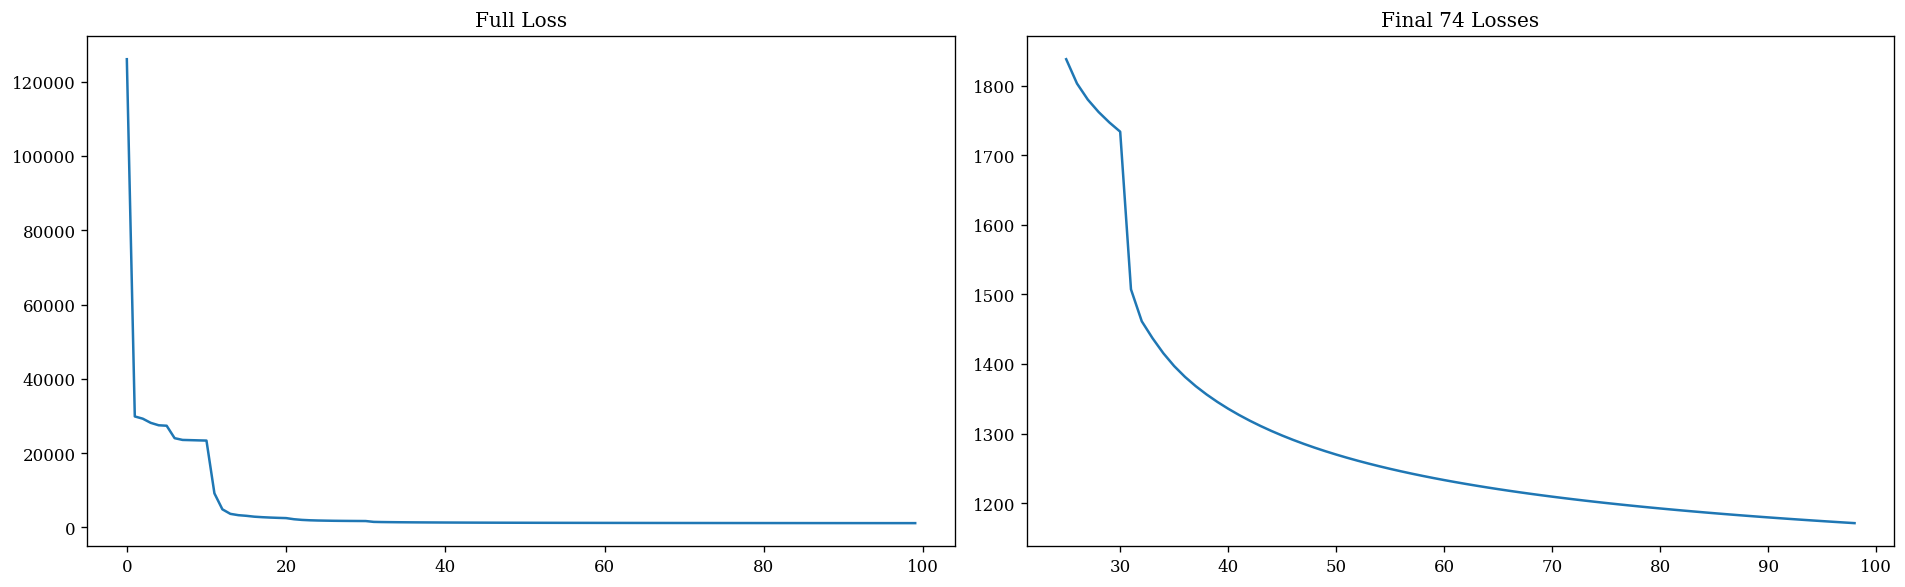

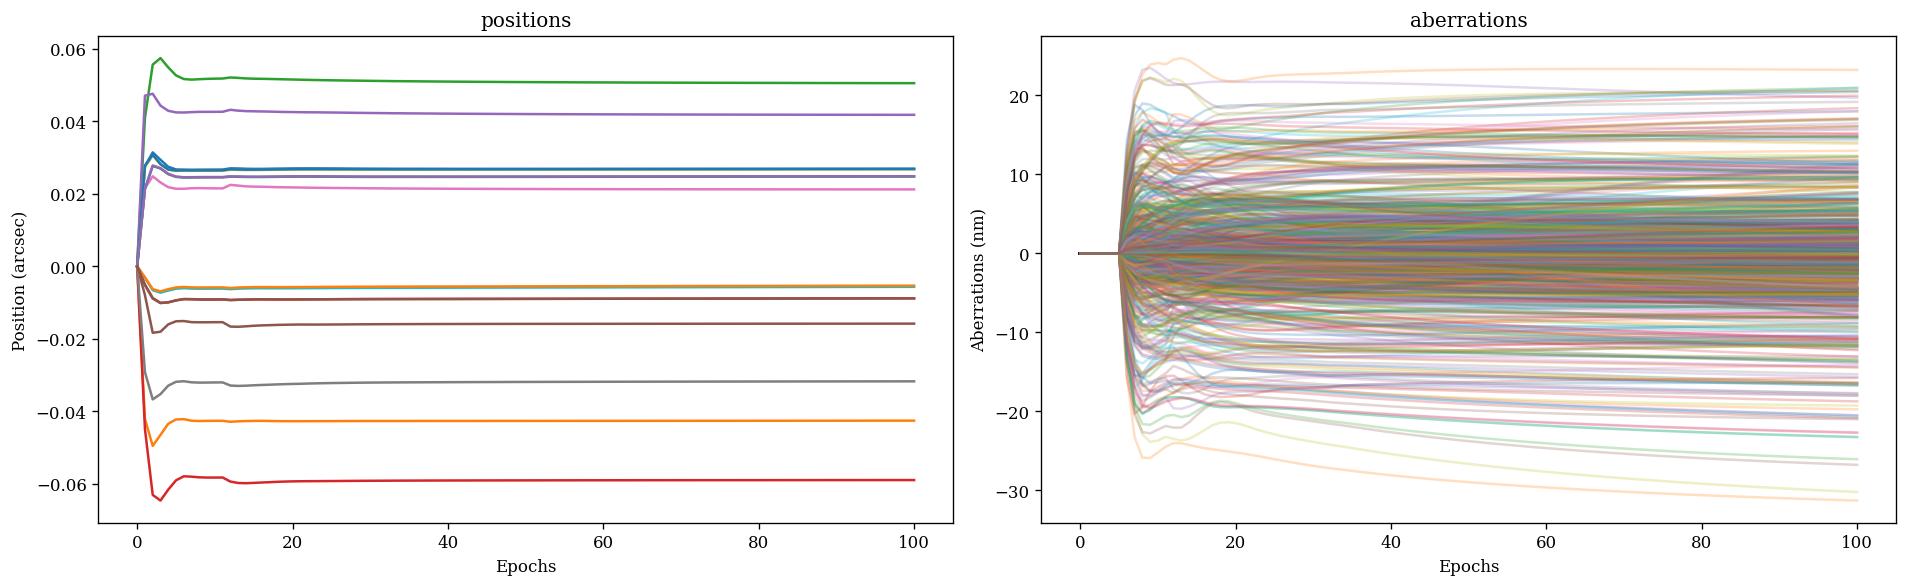

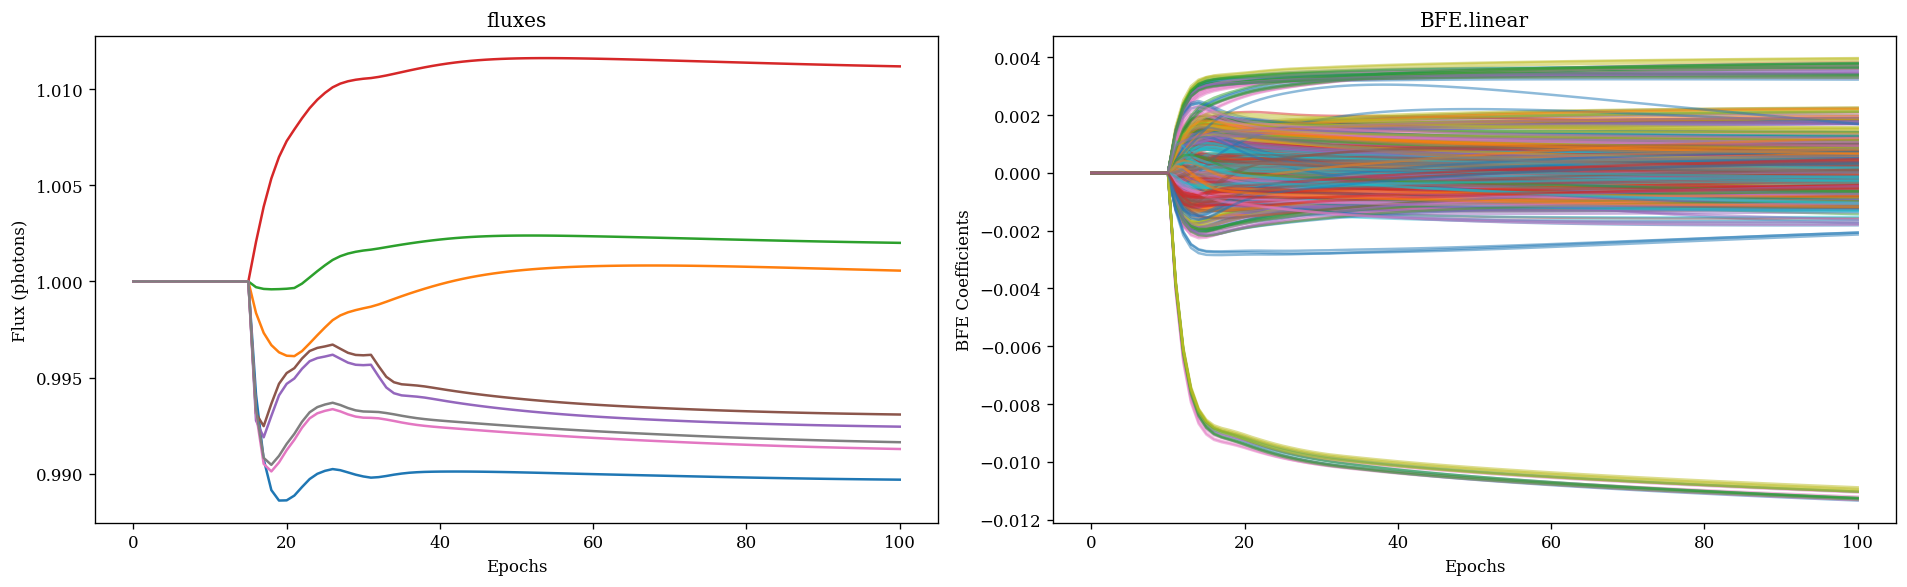

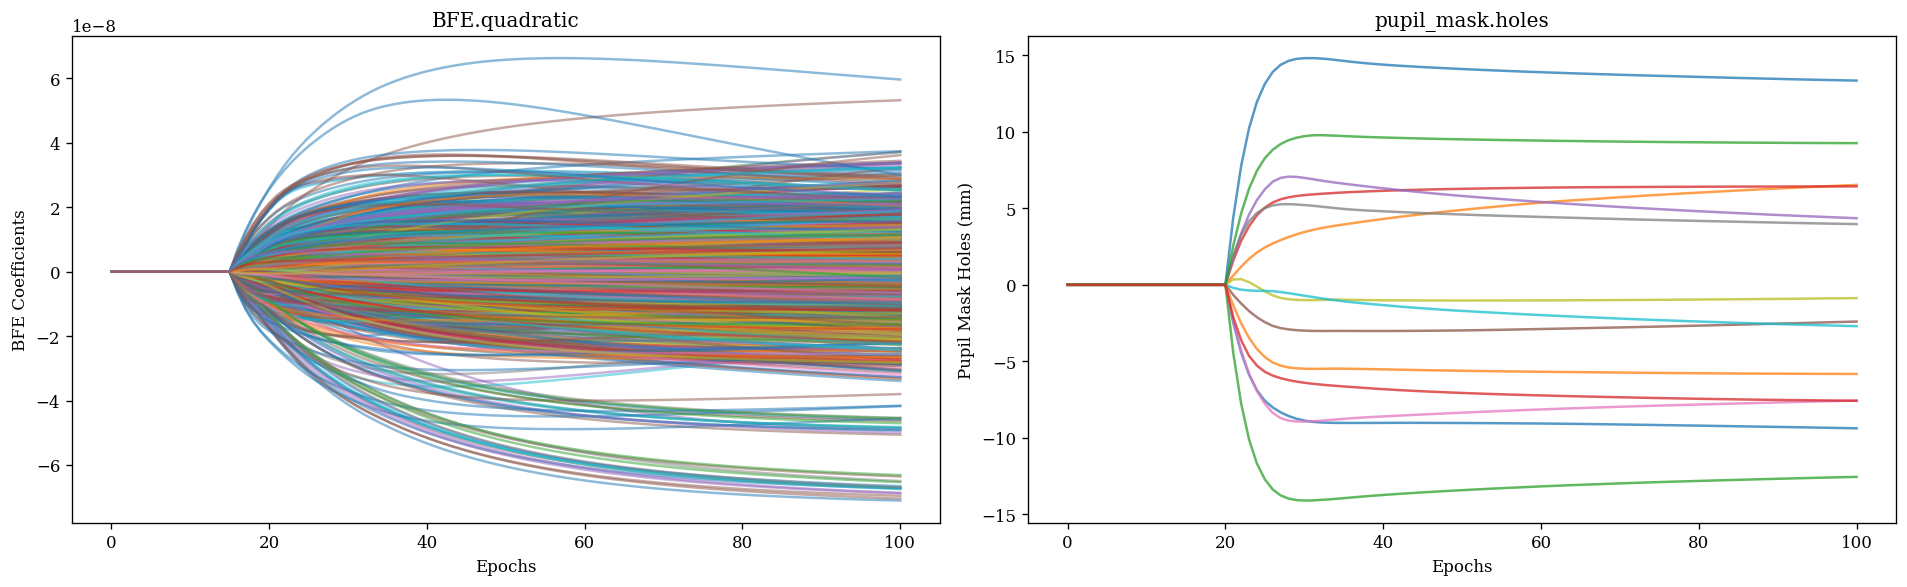

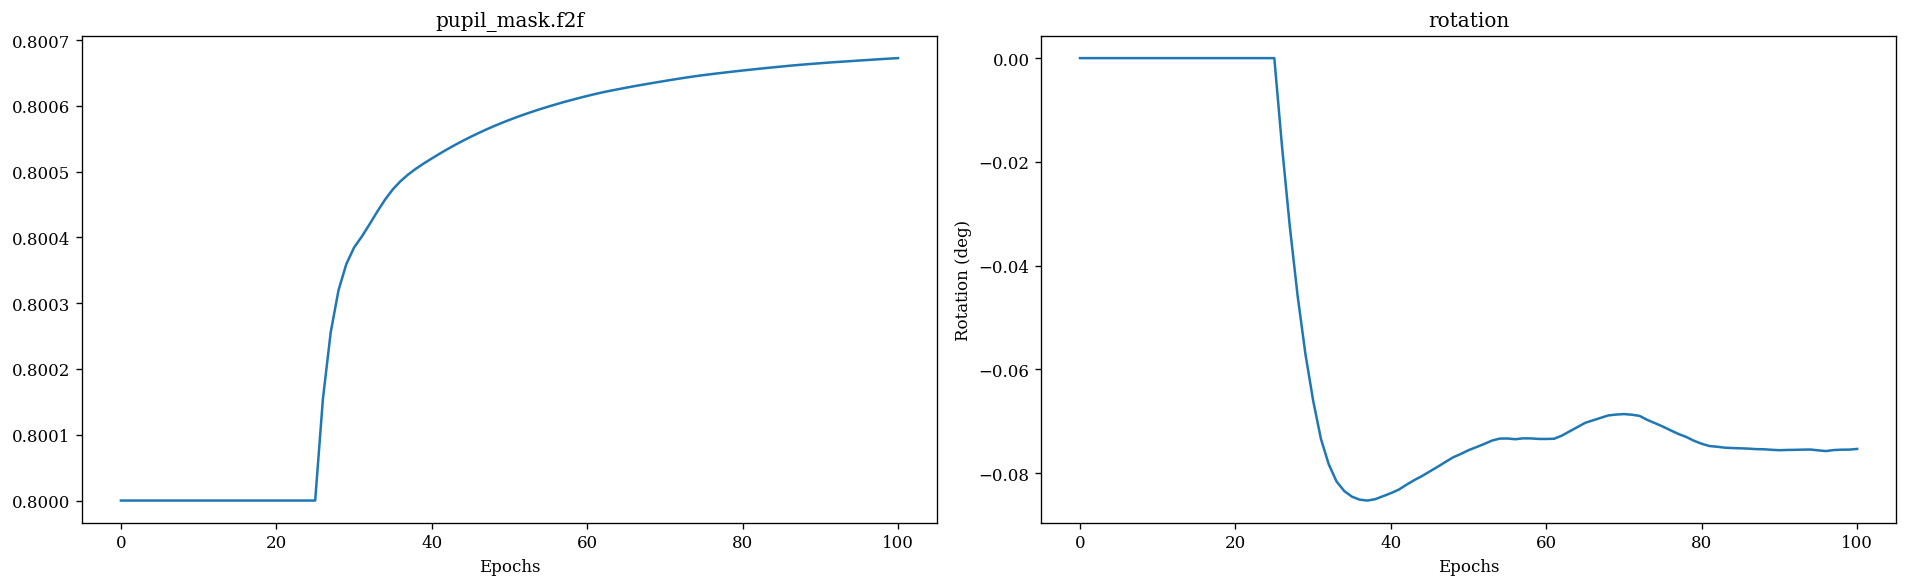

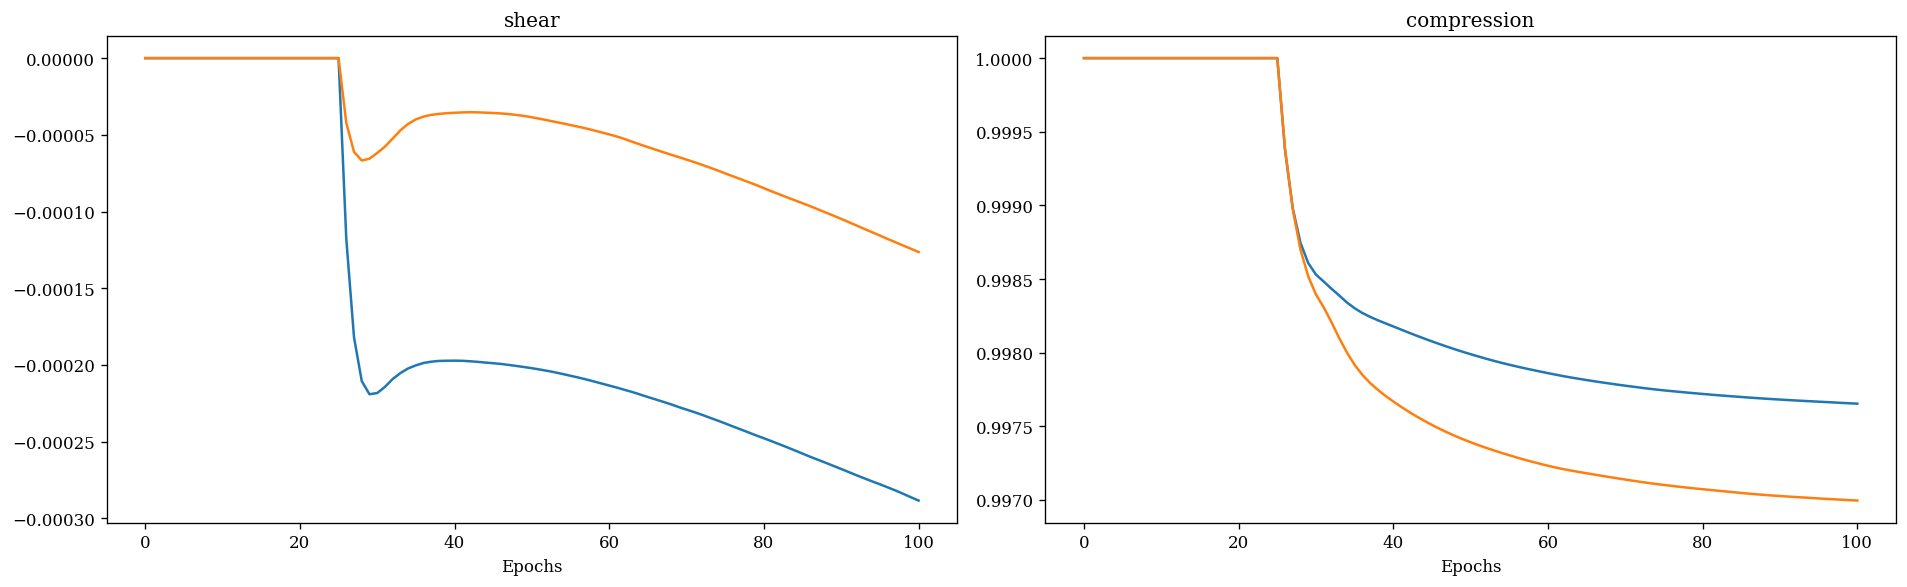

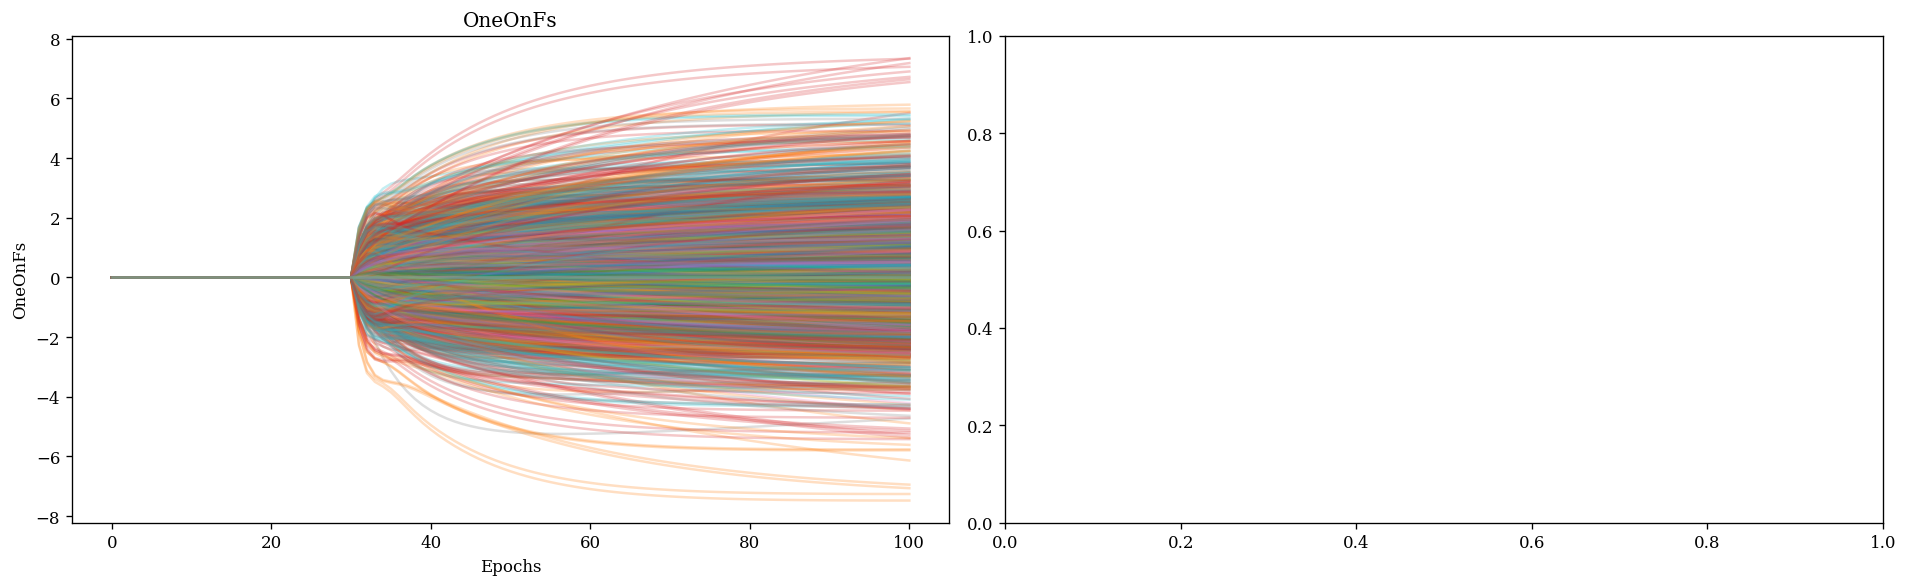

In [9]:
plot_params(np.array(losses), params_out, format_fn, k=25)

In [10]:
def summarise(
    model,
    exposures,
    residuals=False,
    histograms=False,
    flat_field=False,
    up_the_ramp=False,
    up_the_ramp_norm=False,
    full_bias=False,
    aberrations=False,
    pow=0.5,
    k=0.5,
    edge_nan=4,
):
    for exp in exposures:
        print(f"Exposure: {exp.key}")
        print(f"Star: {exp.star}")
        print(f"Filter: {exp.filter}")
        print(f"N ints: {exp.nints}")

        nints = exp.nints
        ramp = model_fn(model, exp)
        data = exp.data

        nan_mask = np.where(np.isnan(data))
        ramp = ramp.at[nan_mask].set(np.nan)

        residual = data - ramp
        loglike_im = exp.loglike_im(ramp)
        final_loss = np.nansum(-loglike_im) / np.prod(np.array(data.shape[-2:]))

        total_cov = nints * exp.covariance
        total_residual = nints * residual
        total_err = vmap(vmap(np.diag, -1, -1), -1, -1)(total_cov) ** 0.5
        norm_res_ramp = total_residual / total_err
        norm_res_vec = exp.to_vec(norm_res_ramp)
        norm_res_vec = norm_res_vec[~np.isnan(norm_res_vec)]

        x = np.nanmax(np.abs(norm_res_vec))
        xs = np.linspace(-x, x, 200)
        ys = jsp.stats.norm.pdf(xs)

        vmax = np.maximum(np.nanmax(np.abs(data)), np.nanmax(np.abs(ramp)))
        vmin = np.minimum(np.nanmin(np.abs(data)), np.nanmin(np.abs(ramp)))

        skip = False
        if np.isnan(vmin) or np.isnan(vmax):
            skip = True

        if not skip:
            if residuals:
                norm = colors.PowerNorm(gamma=0.5, vmin=-vmin, vmax=vmax)
                inferno.set_bad("k", 0.5)
                seismic.set_bad("k", 0.5)

                plt.figure(figsize=(15, 4))
                plt.subplot(1, 3, 1)
                plt.title(r"Mean Data Ramp $^{}$".format(pow))
                plt.imshow(data.mean(0), cmap=inferno, norm=norm)
                plt.colorbar()

                plt.subplot(1, 3, 2)
                plt.title(f"Mean Model Ramp $^{pow}$")
                plt.imshow(ramp.mean(0), cmap=inferno, norm=norm)
                plt.colorbar()

                plt.subplot(1, 3, 3)
                plt.title(f"Pixel neg log likelihood: {final_loss:,.1f}")
                plt.imshow(-loglike_im, cmap=inferno)
                plt.colorbar()

                plt.tight_layout()
                plt.show()

            if histograms:

                plt.figure(figsize=(15, 4))
                ax = plt.subplot(1, 3, 1)
                ax.set_title(f"Noise normalised residual sigma: {norm_res_vec.std():.3}")
                ax.hist(norm_res_vec.flatten(), bins=50, density=True)

                ax2 = ax.twinx()
                ax2.plot(xs, ys, c="k")
                ax2.set_ylim(0)

                ax = plt.subplot(1, 3, 2)
                ax.set_title(f"Noise normalised residual sigma: {norm_res_vec.std():.3}")
                bins = ax.hist(norm_res_vec.flatten(), bins=50)[0]
                ax.semilogy()

                # ax2 = ax.twinx()
                # ax2.plot(xs, bins.max() * ys, c="k")
                # ax2.semilogy()

                v = np.nanmax(np.abs(norm_res_ramp.mean(0)))
                plt.subplot(1, 3, 3)
                plt.title("Mean noise normalised ramp residual")
                plt.imshow(norm_res_ramp.mean(0), vmin=-v, vmax=v, cmap=seismic)
                plt.colorbar()

                plt.tight_layout()
                plt.show()

        if flat_field:
            plt.figure(figsize=(15, 4))

            plt.subplot(1, 3, 1)
            plt.title("Mean Pixel Response Function")
            v = np.max(np.abs(model.detector.sensitivity.SRF - 1))
            plt.imshow(model.detector.sensitivity.SRF, vmin=1 - v, vmax=1 + v, cmap=seismic)
            plt.colorbar()

            FF = dlu.resize(model.detector.sensitivity.FF, 80)

            plt.subplot(1, 3, 2)
            plt.title("Flat Field")
            plt.imshow(FF, vmin=0, vmax=2, cmap=seismic)
            plt.colorbar()

            plt.subplot(1, 3, 3)
            plt.title("Flat Field Histogram")
            plt.hist(FF.flatten(), bins=100)
            # plt.xlim(0, 2)
            plt.show()

        if up_the_ramp:
            plt.figure(figsize=(20, 16))
            plt.suptitle("Up The Ramp Residuals")

            for i in range(exp.ngroups):
                plt.subplot(4, 4, i + 1)
                v = np.nanmax(np.abs(residual[i]))
                plt.imshow(residual[i], cmap=seismic, vmin=-v, vmax=v)
                plt.colorbar()
            plt.show()

        if up_the_ramp_norm:
            plt.figure(figsize=(20, 16))
            plt.suptitle("Up The Ramp Residuals")

            for i in range(exp.ngroups):
                plt.subplot(4, 4, i + 1)
                v = np.nanmax(np.abs(norm_res_ramp[i]))
                plt.imshow(norm_res_ramp[i], cmap=seismic, vmin=-v, vmax=v)
                plt.colorbar()
            plt.show()

        if full_bias:
            coeffs = model.OneOnFs[exp.key]
            nan_mask = 1 + (np.nan * np.isnan(data.sum(0)))
            bias = nan_mask * model.biases[exp.key]

            plt.figure(figsize=(15, 4))
            plt.subplot(1, 2, 1)
            plt.title("Pixel Bias")
            plt.imshow(bias, cmap=inferno)
            plt.colorbar()

            plt.subplot(2, 4, (3, 4))
            plt.title("1/f Gradient")
            plt.imshow(coeffs[..., 0])
            plt.colorbar()
            plt.xlabel("x-pixel")
            plt.ylabel("Group")

            plt.subplot(2, 4, (7, 8))
            plt.title("1/f Bias")
            plt.imshow(coeffs[..., 1])
            plt.colorbar()
            plt.xlabel("x-pixel")
            plt.ylabel("Group")

            plt.tight_layout()
            plt.show()

        if aberrations:
            # Get the AMI mask and applied mask
            optics = model.optics.set("coefficients", model.aberrations[exp.key])
            applied_mask = optics.pupil_mask.gen_AMI(optics.wf_npixels, optics.diameter)

            # Get the applied opds in nm and flip to match the mask
            static_opd = np.flipud(optics.pupil.opd) * 1e9
            added_opd = np.flipud(optics.basis_opd) * 1e9
            static_opd = static_opd.at[np.where(~(applied_mask > 1e-6))].set(np.nan)
            added_opd = added_opd.at[np.where(~(applied_mask > 1e-6))].set(np.nan)
            mirror_opd = static_opd + added_opd

            plt.figure(figsize=(15, 4))

            v = np.nanmax(np.abs(static_opd))
            plt.subplot(1, 3, 1)
            plt.title("Static OPD")
            plt.imshow(static_opd, cmap=seismic, vmin=-v, vmax=v)
            plt.colorbar()

            v = np.nanmax(np.abs(added_opd))
            plt.subplot(1, 3, 2)
            plt.title("Added OPD")
            plt.imshow(added_opd, cmap=seismic, vmin=-v, vmax=v)
            plt.colorbar()

            v = np.nanmax(np.abs(mirror_opd))
            plt.subplot(1, 3, 3)
            plt.title("Total OPD")
            plt.imshow(mirror_opd, cmap=seismic, vmin=-v, vmax=v)
            plt.colorbar()

            plt.tight_layout()
            plt.show()

Exposure: jw01093017001_03102_00003
Star: HD-37093
Filter: F480M
N ints: 61


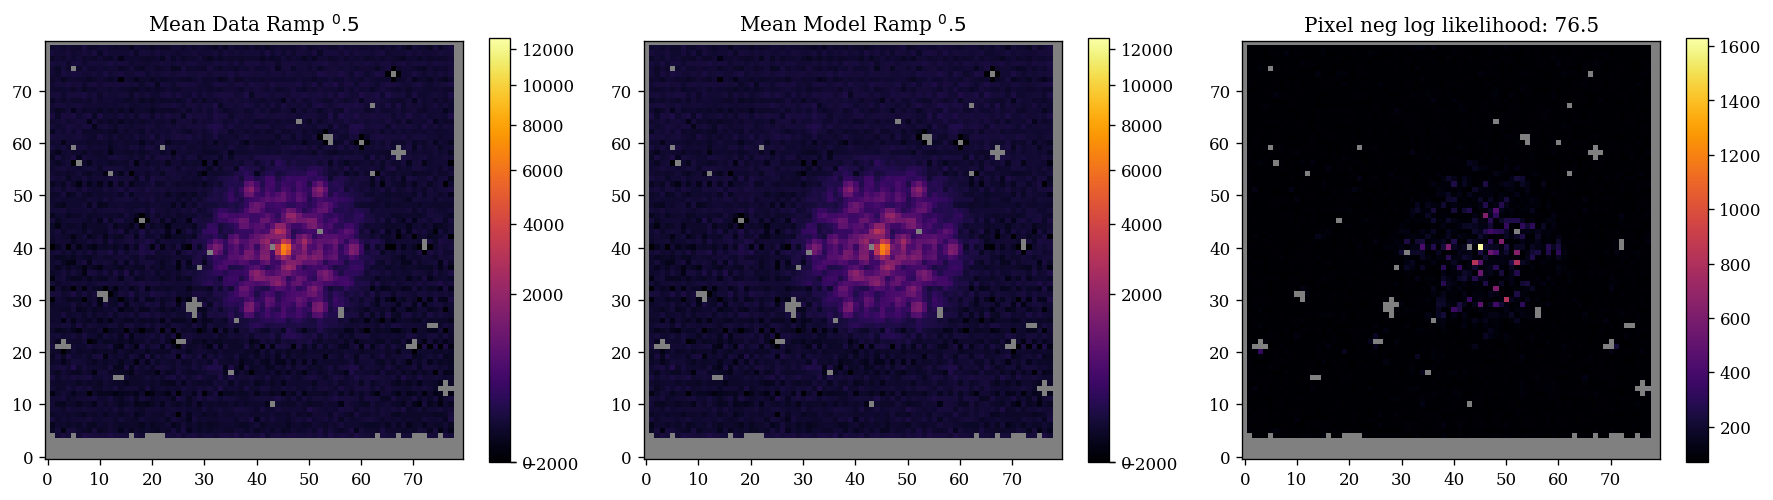

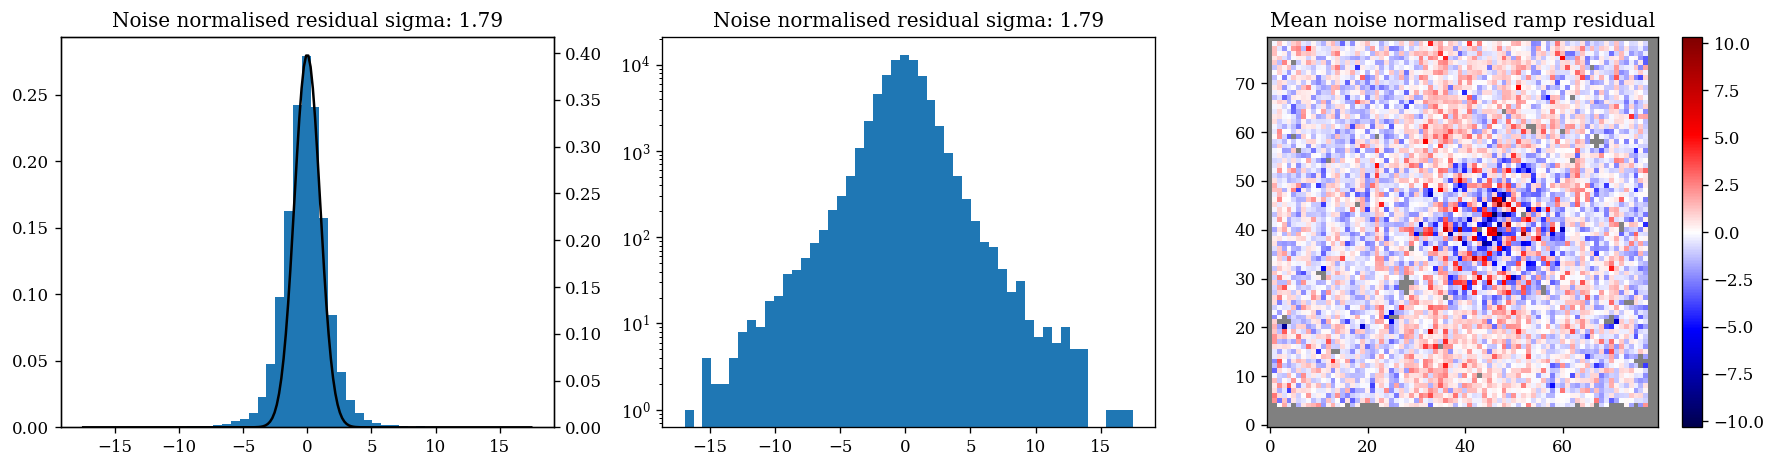

Exposure: jw01093016001_03104_00001
Star: HD-37093
Filter: F380M
N ints: 118


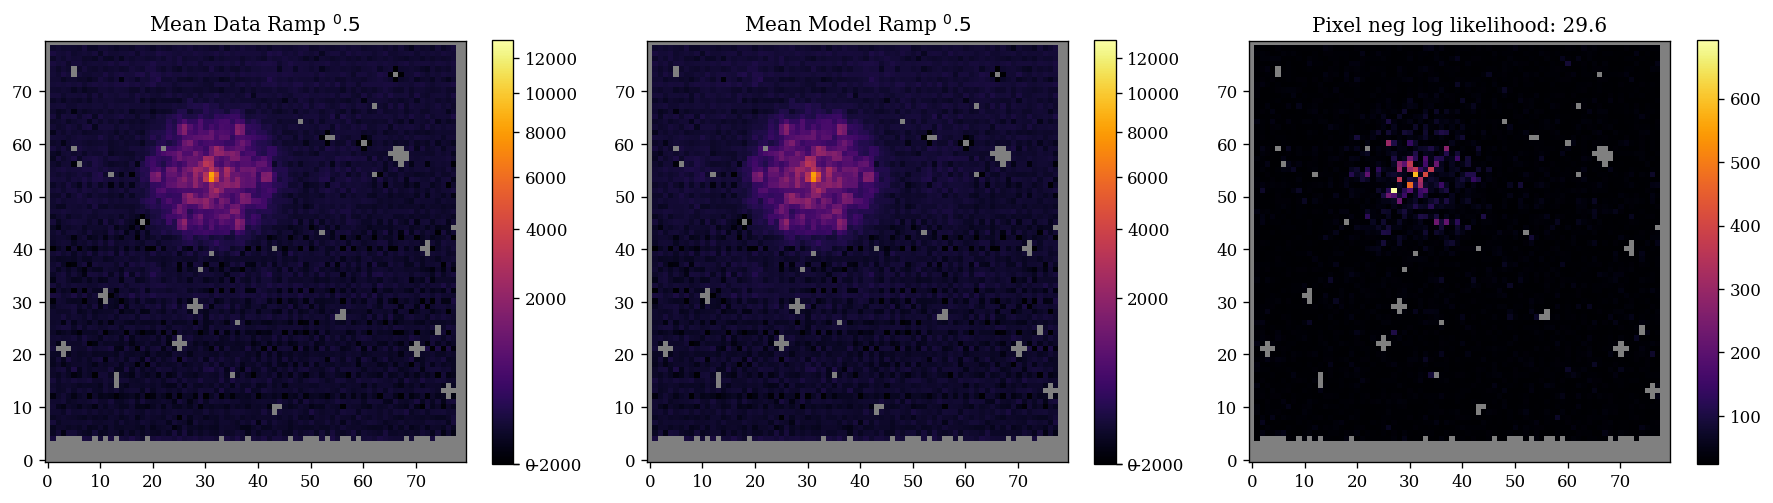

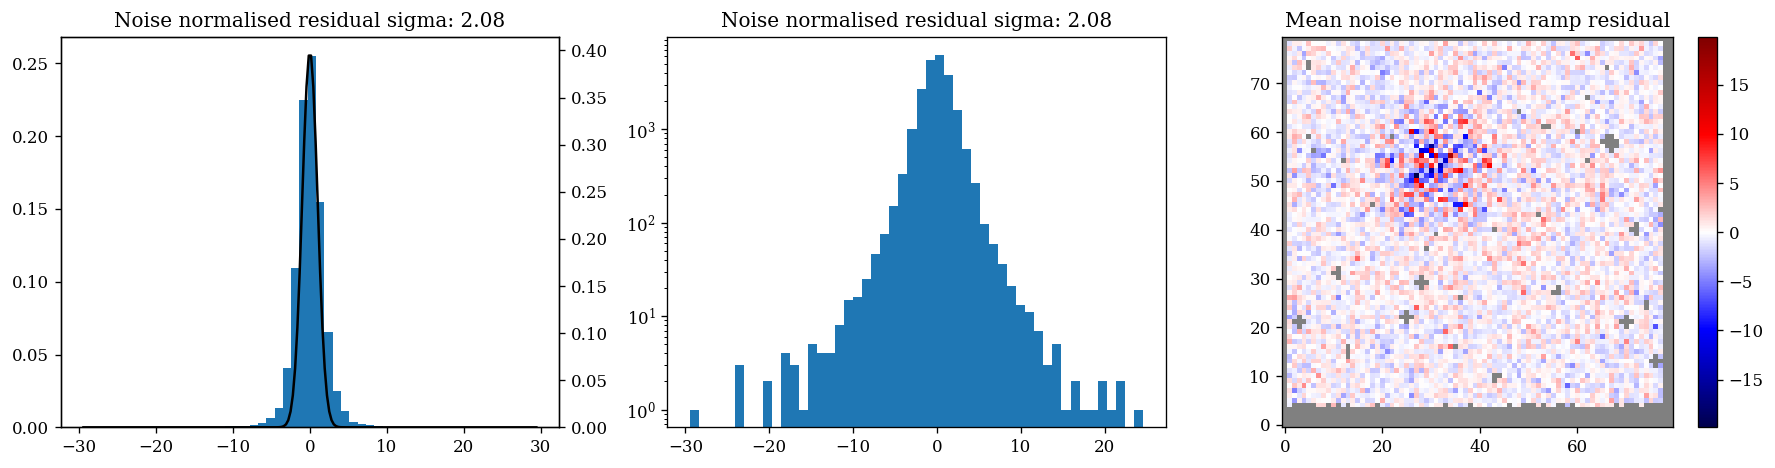

Exposure: jw01093020001_03102_00014
Star: HD-36805
Filter: F480M
N ints: 65


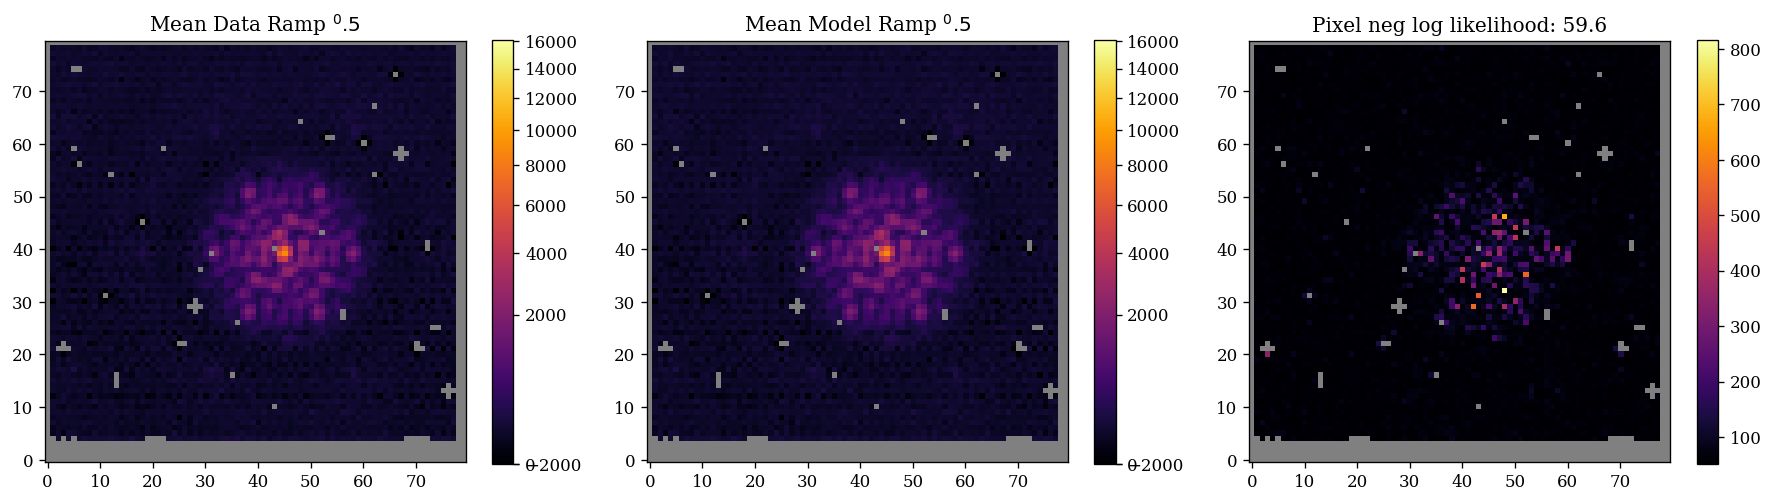

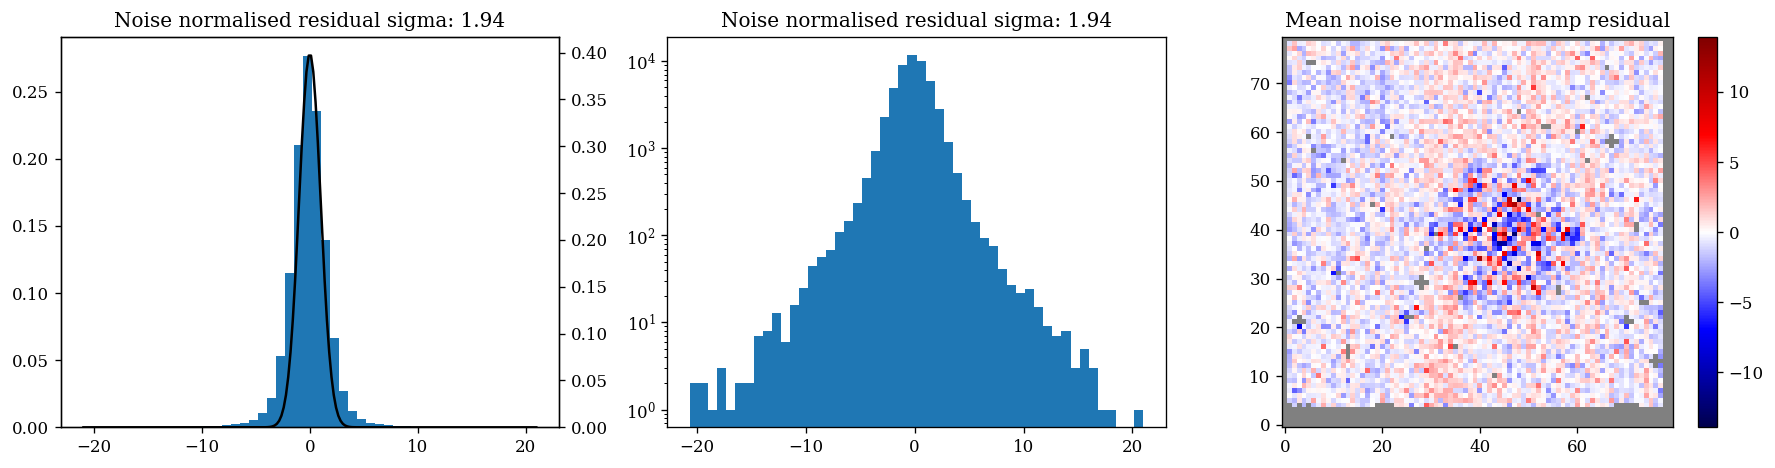

Exposure: jw01093018001_03102_00001
Star: HD-36805
Filter: F480M
N ints: 65


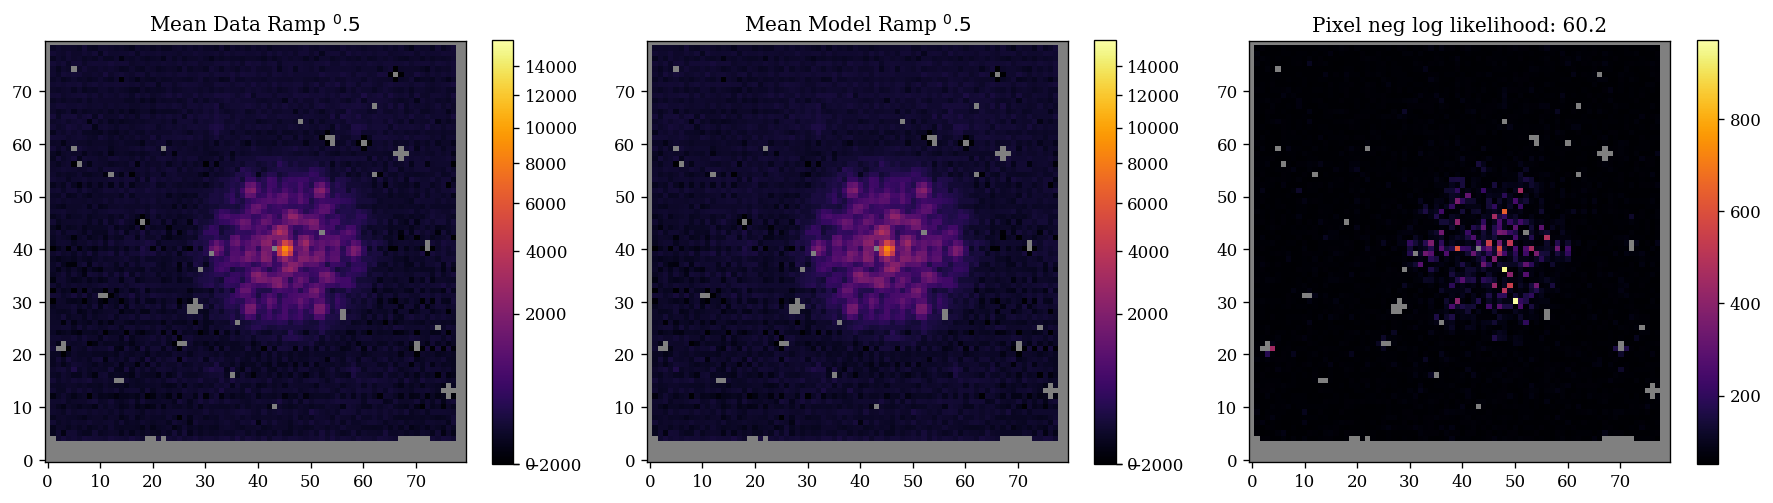

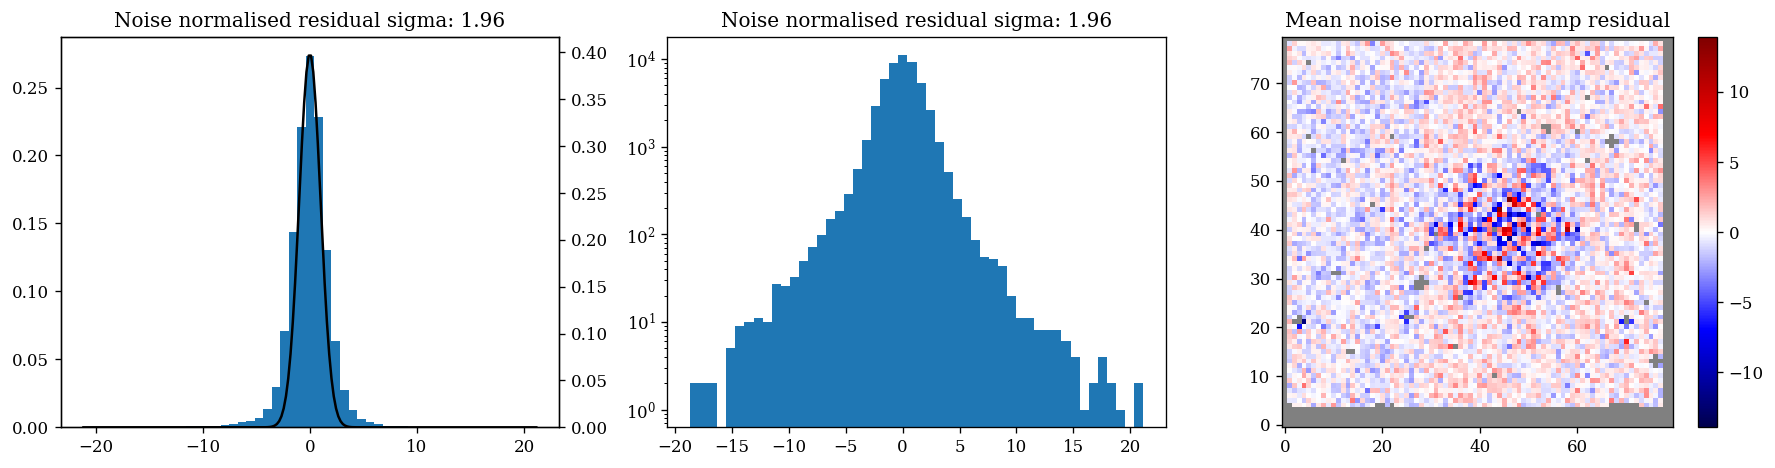

Exposure: jw01386012001_03102_00001
Star: HD-116084
Filter: F380M
N ints: 10000


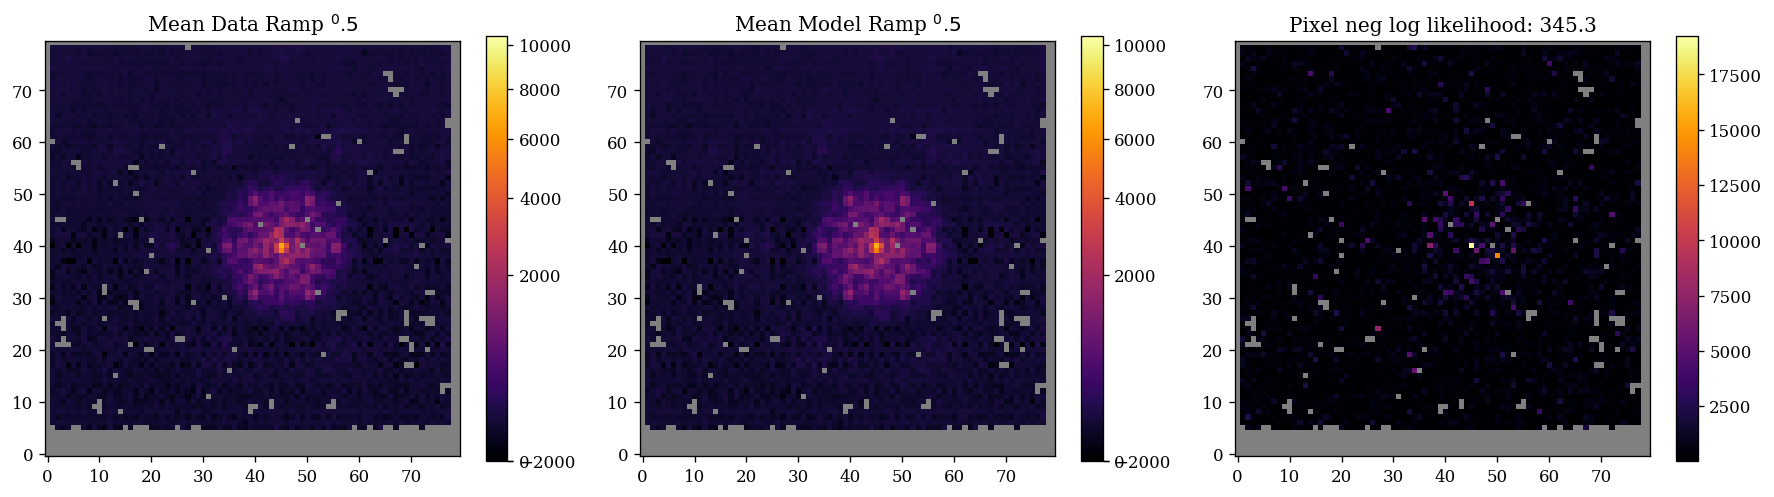

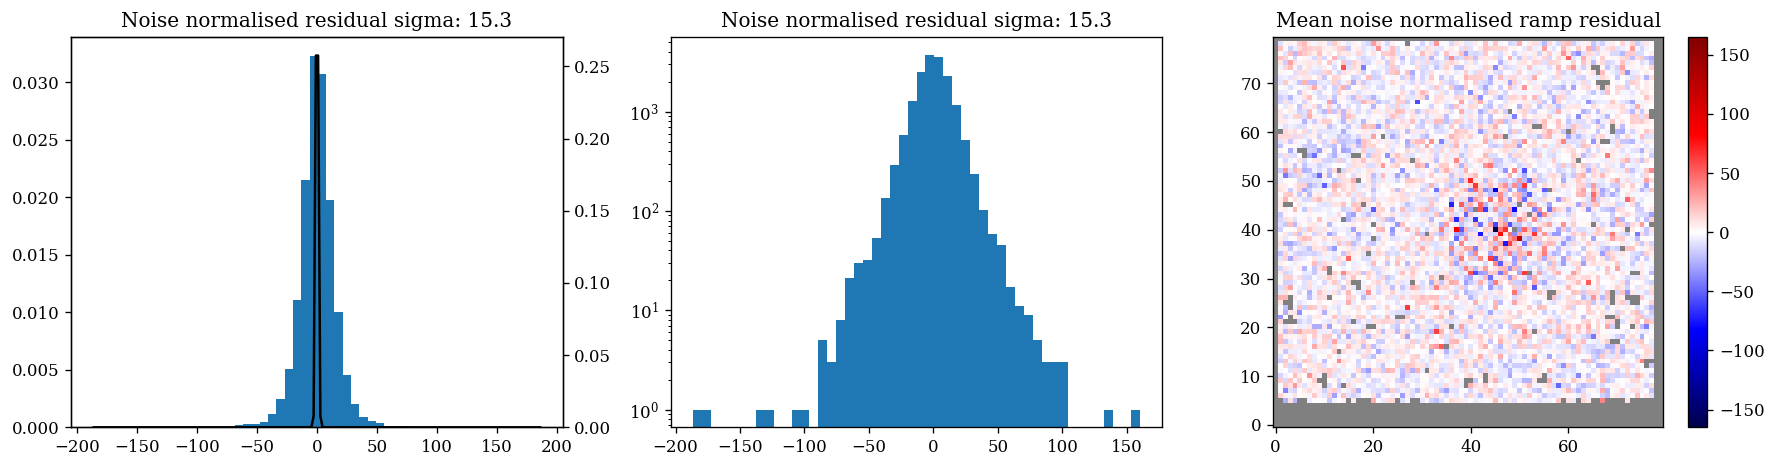

Exposure: jw01386012001_03103_00001
Star: HD-116084
Filter: F380M
N ints: 6000


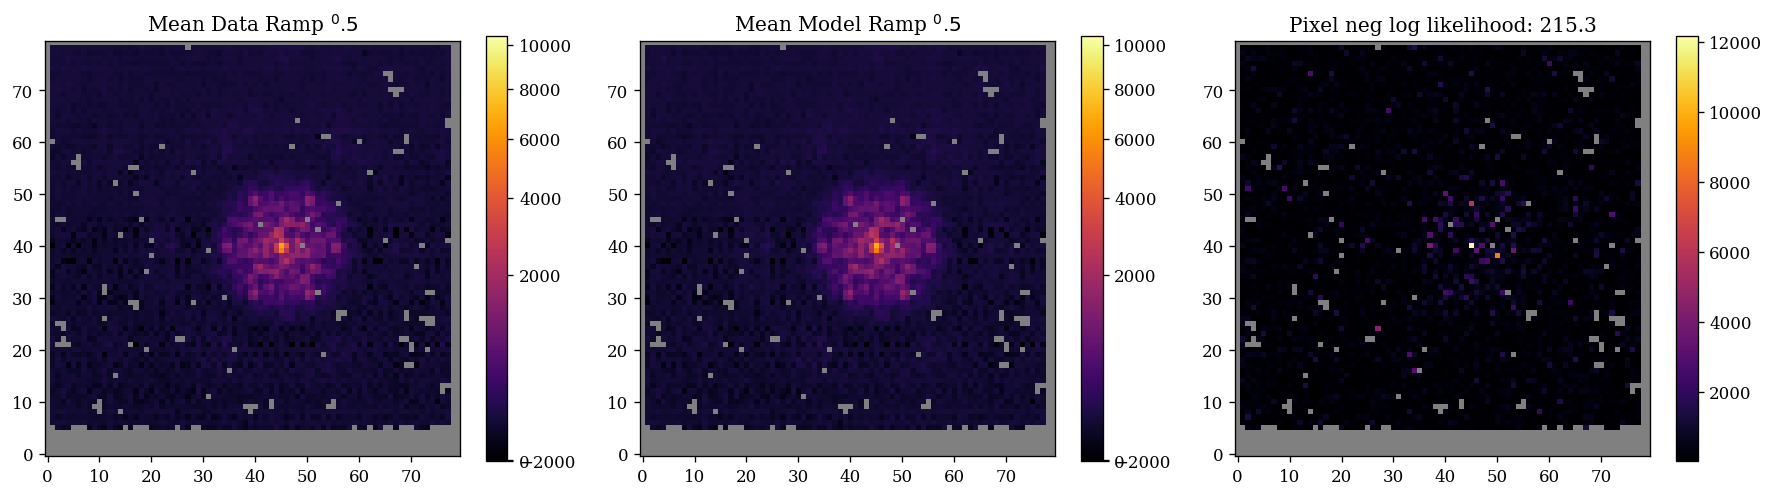

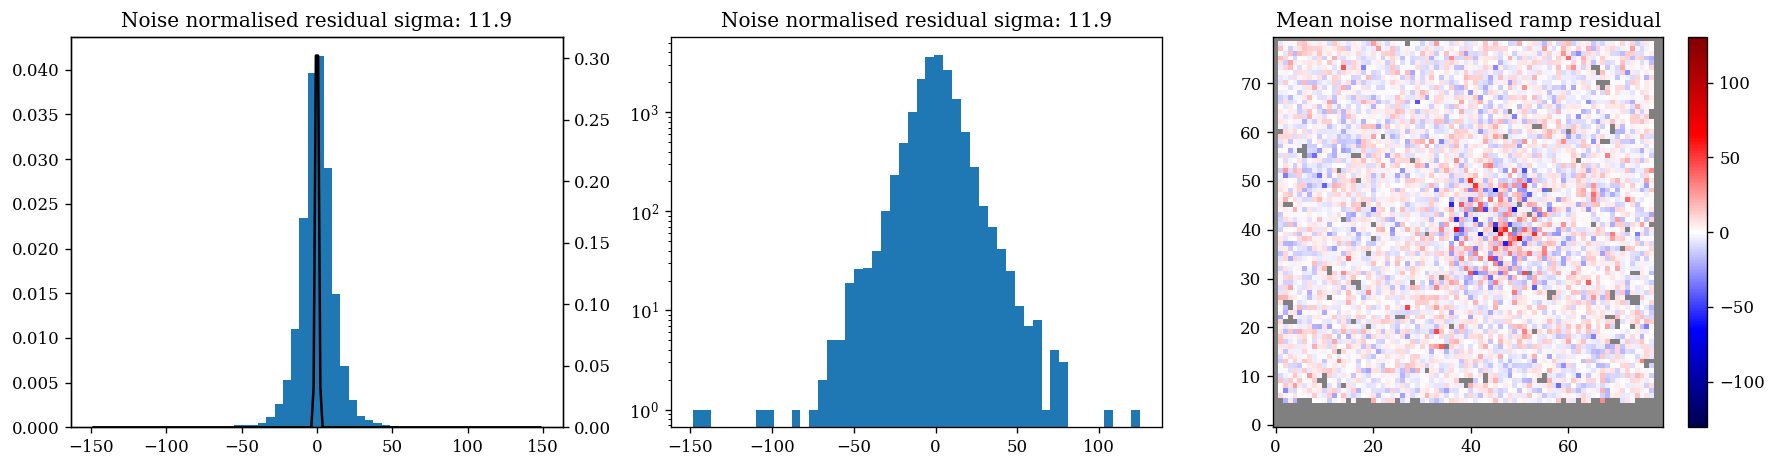

Exposure: jw01386010001_03102_00001
Star: HD-115842
Filter: F380M
N ints: 10000


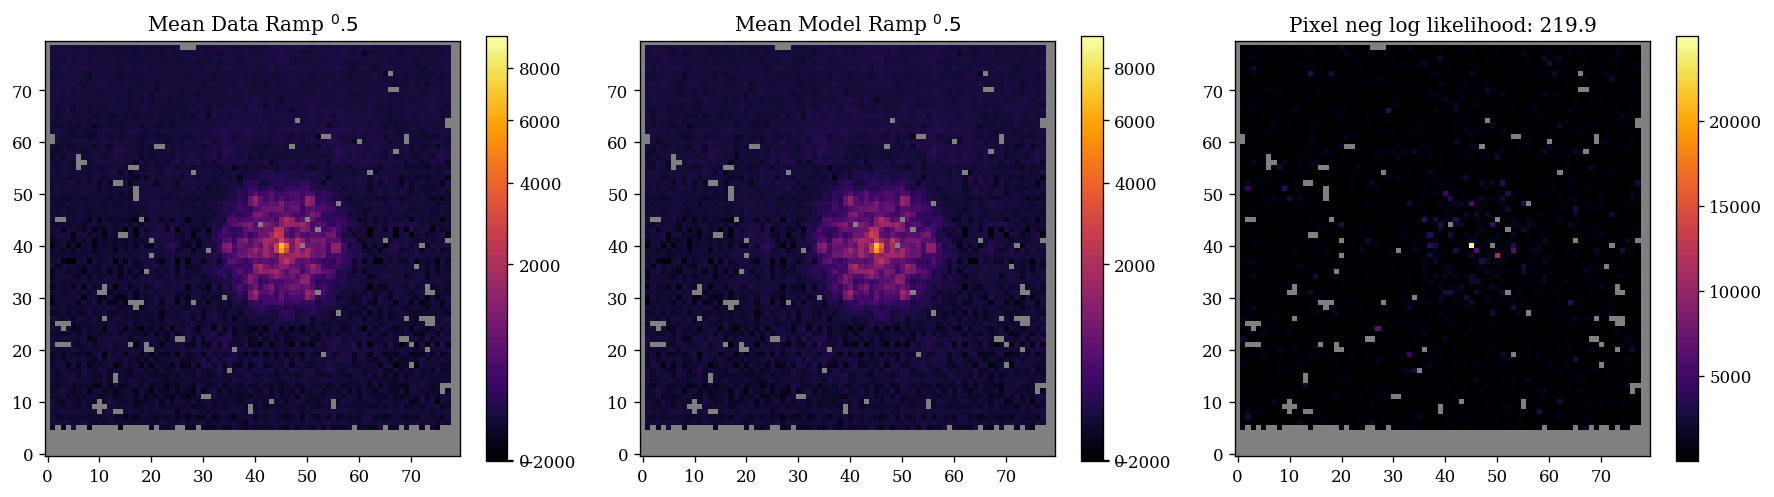

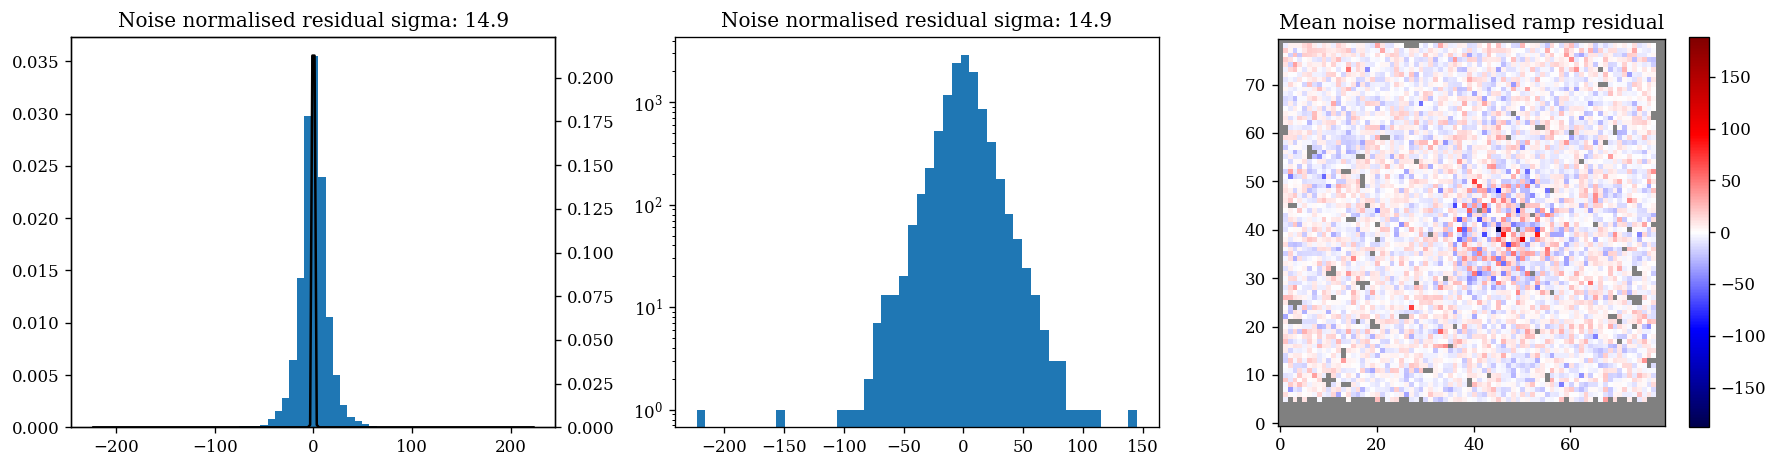

Exposure: jw01386010001_03103_00001
Star: HD-115842
Filter: F380M
N ints: 5500


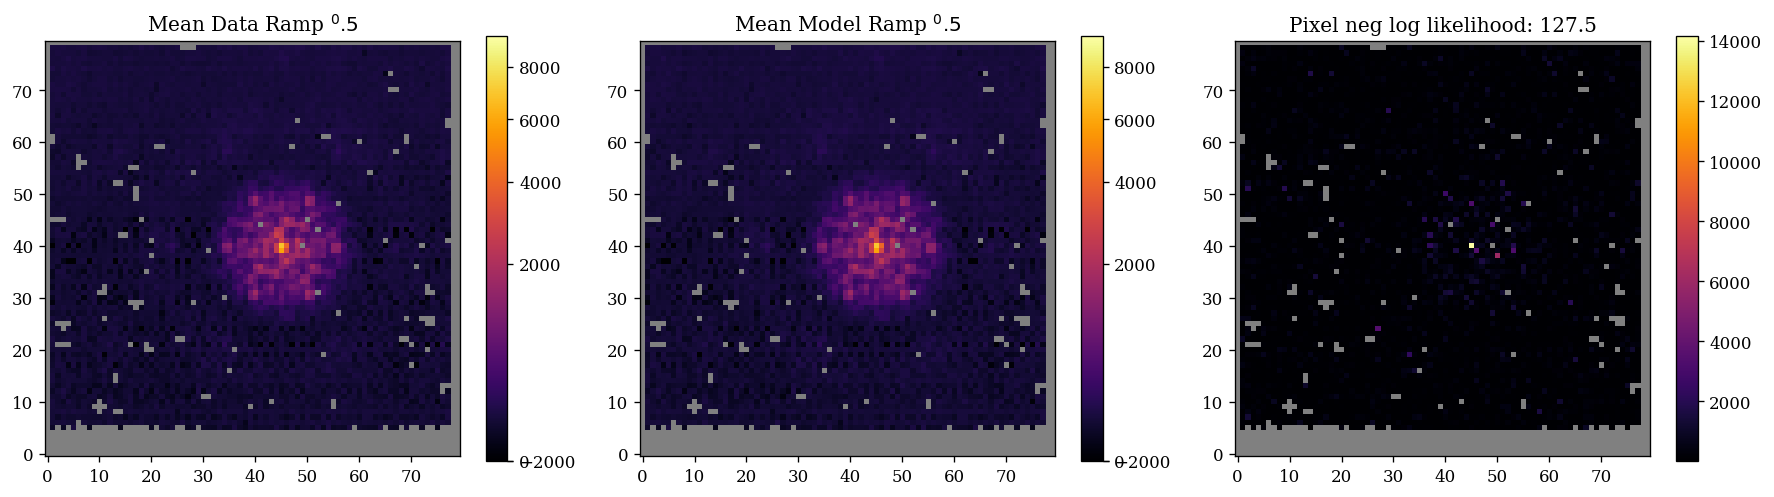

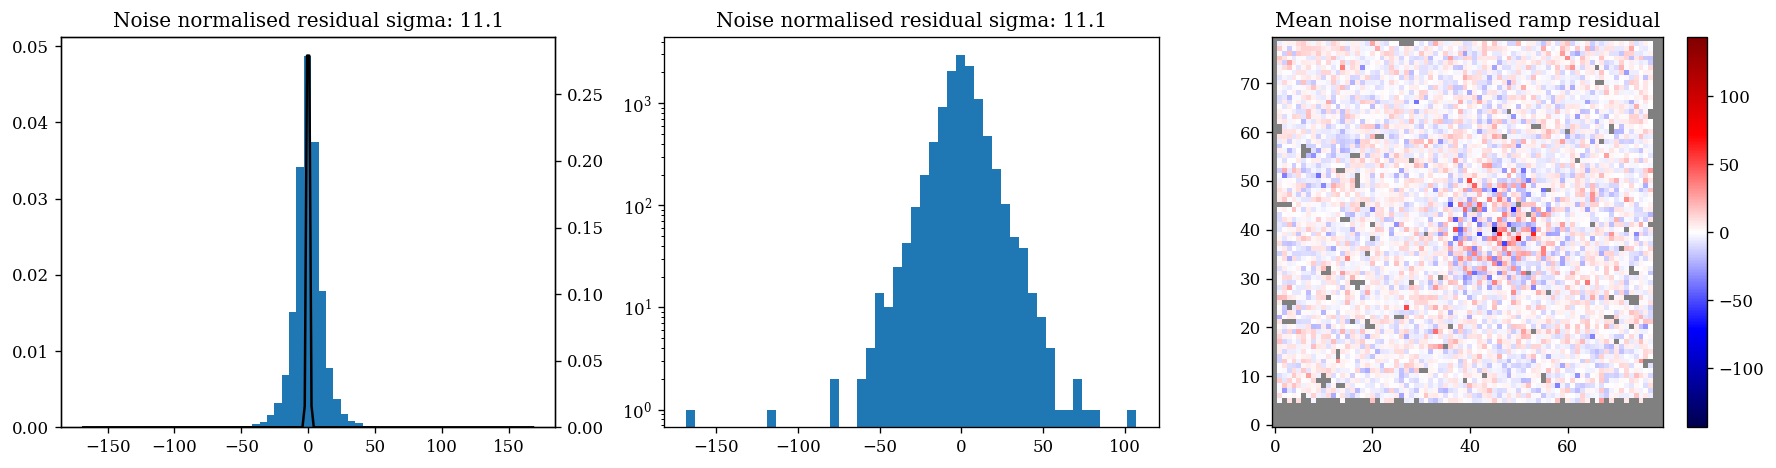

In [11]:
summarise(
    final_model,
    exposures,
    residuals=True,
    histograms=True,
    # flat_field=True,
    # up_the_ramp=True,
    # up_the_ramp_norm=True,
    # full_bias=True,
    # aberrations=True,
)

In [12]:
# from zodiax.experimental import serialise

# serialise(f"files/reference/PolyBFETrained", final_model.BFE)
# serialise(f"files/reference/conv_AMI_mask", final_model.pupil_mask)

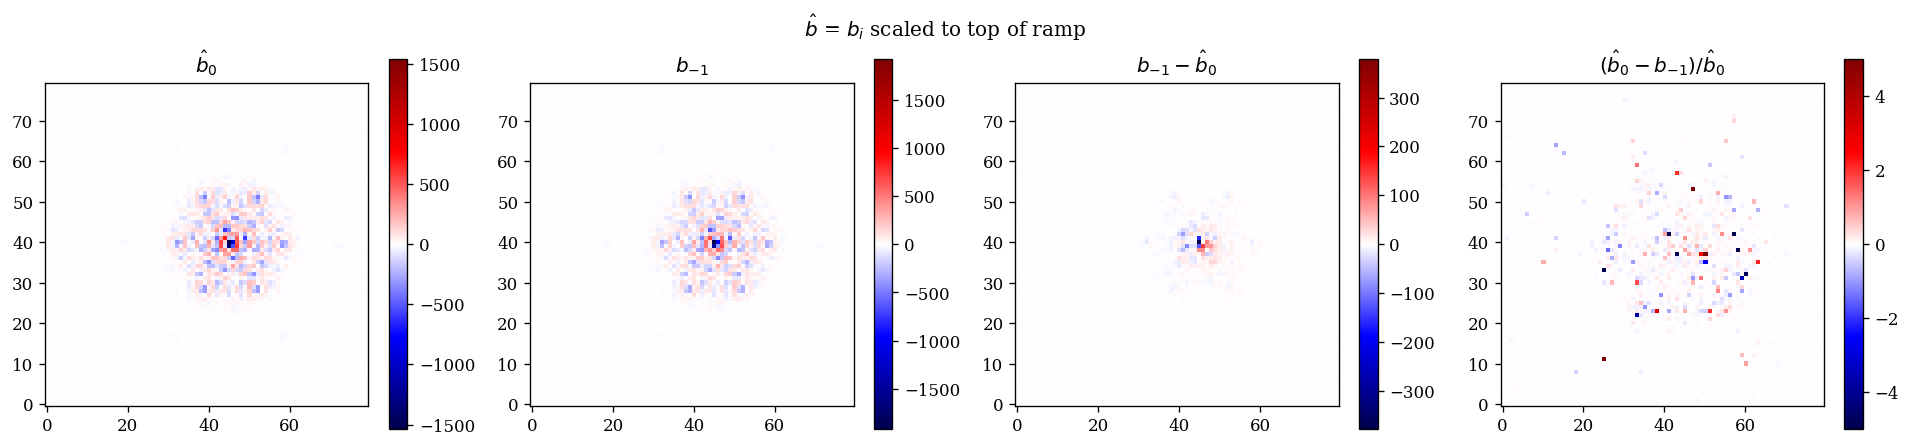

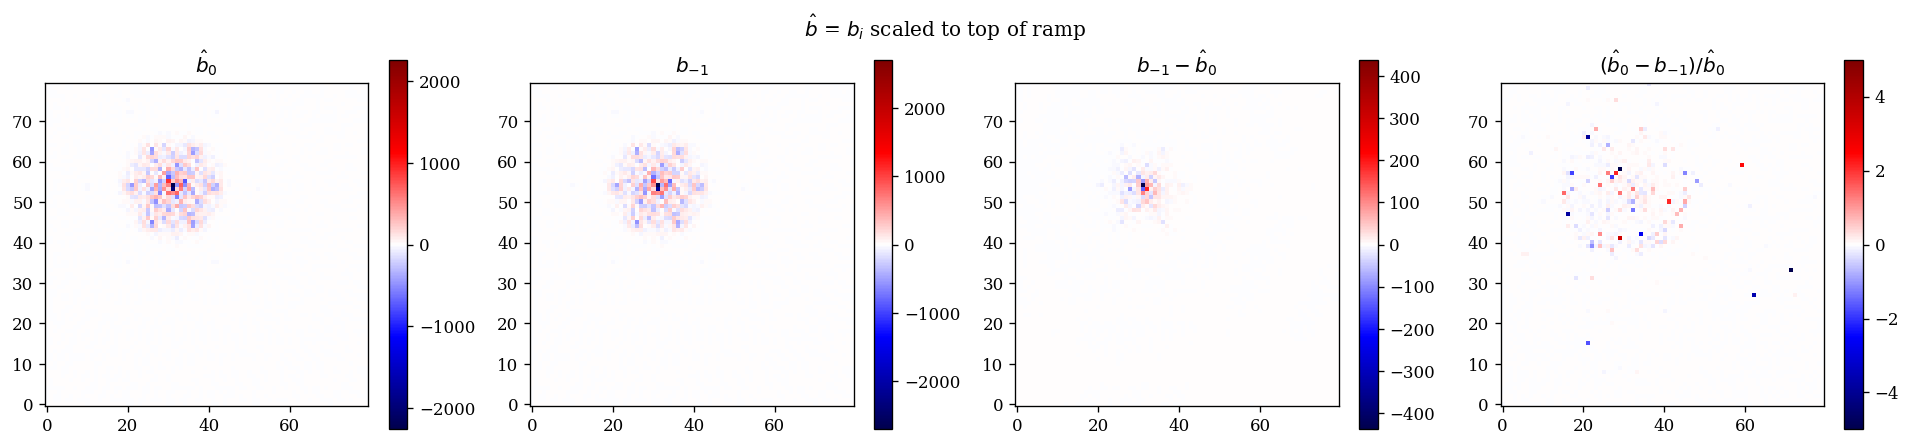

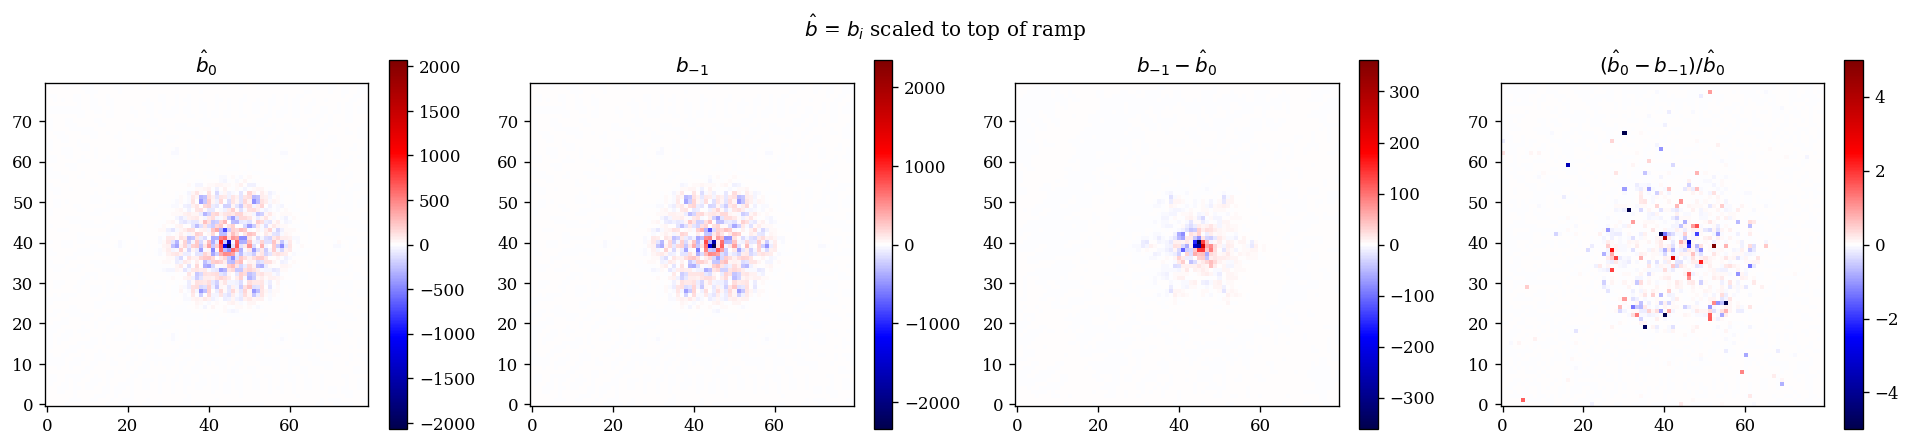

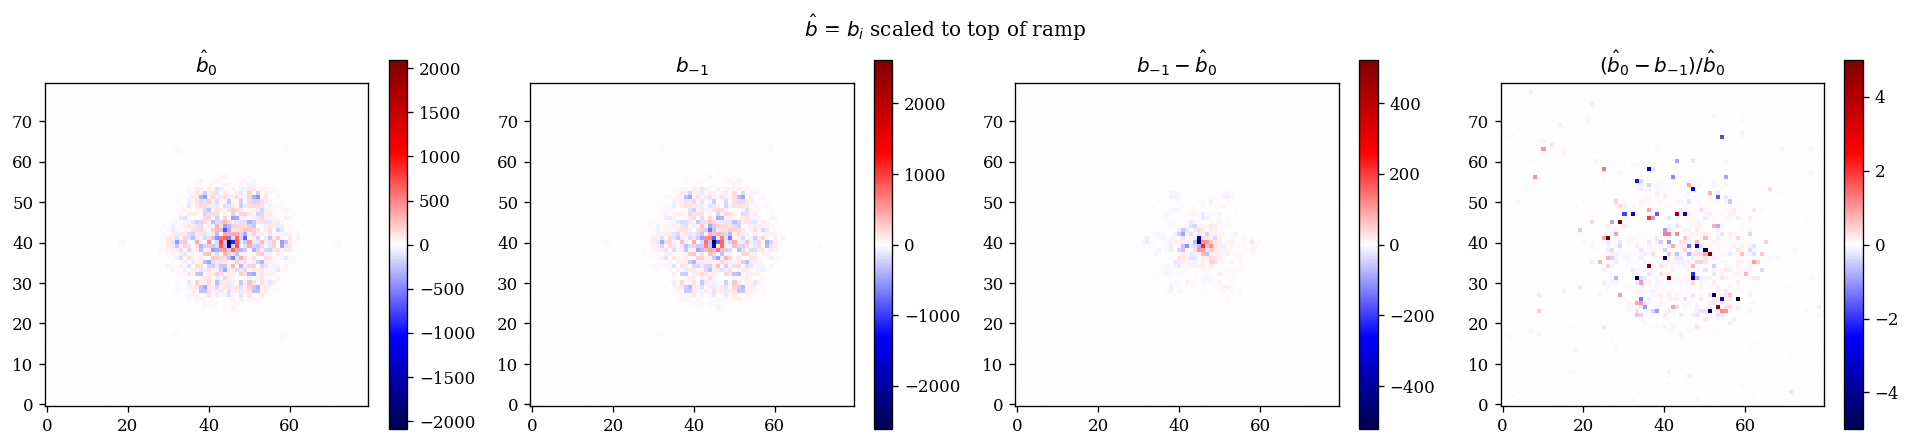

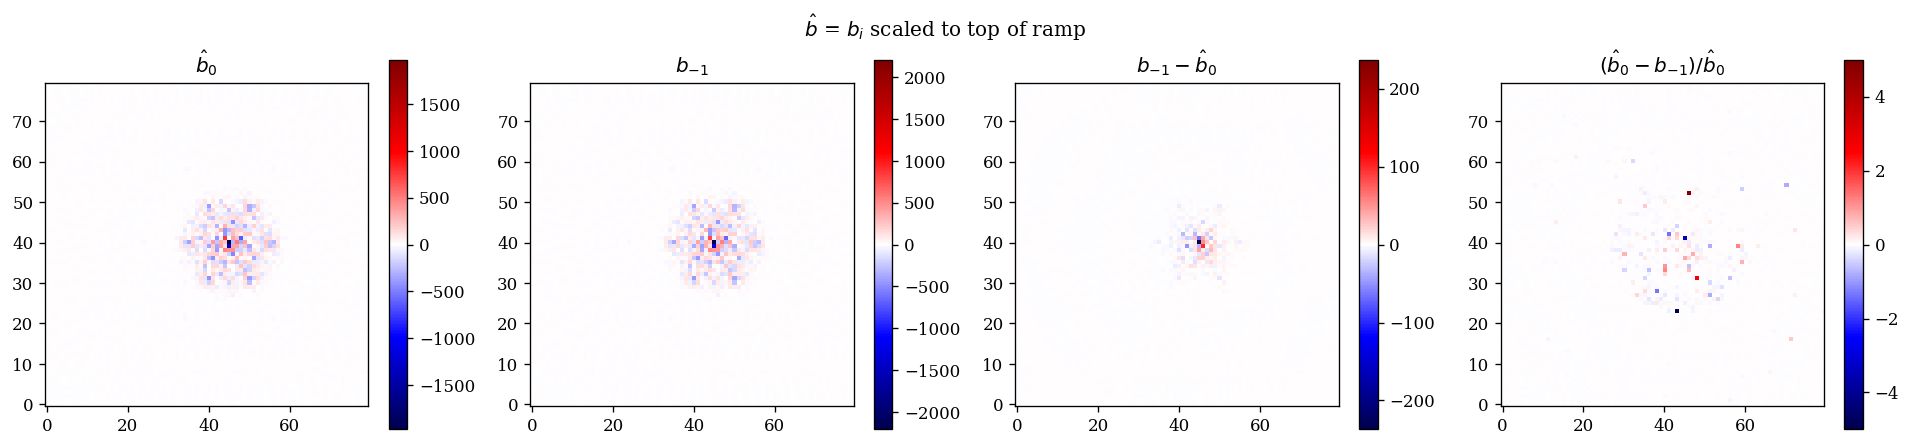

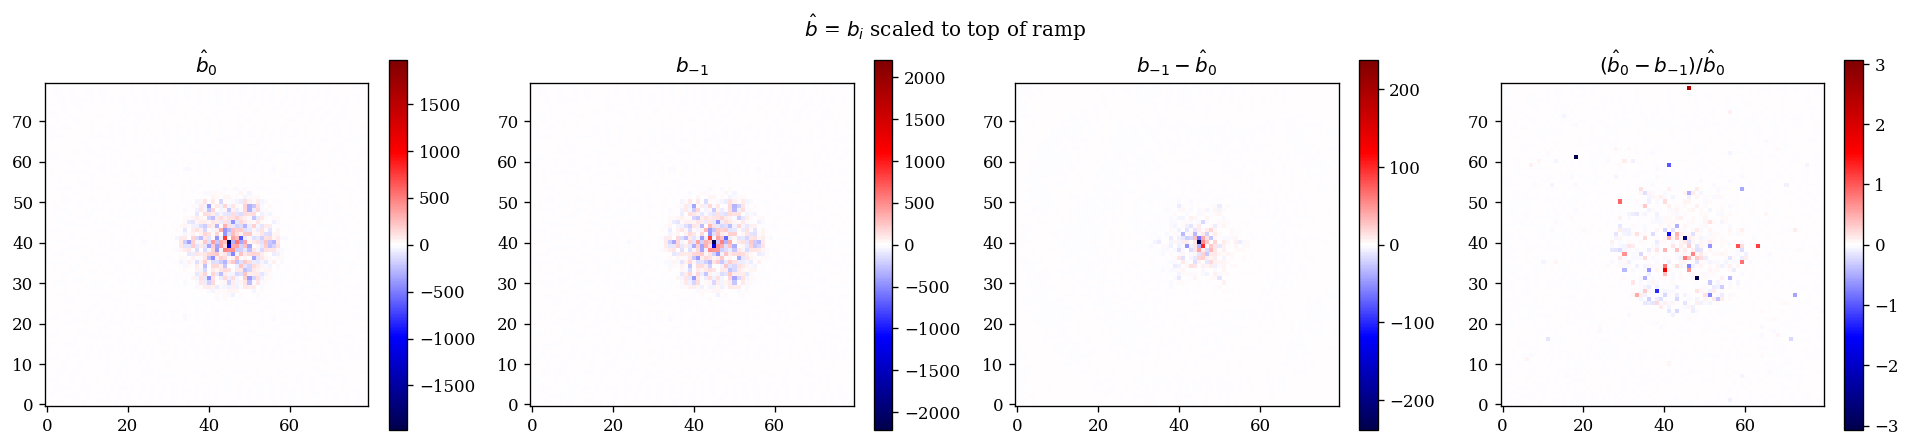

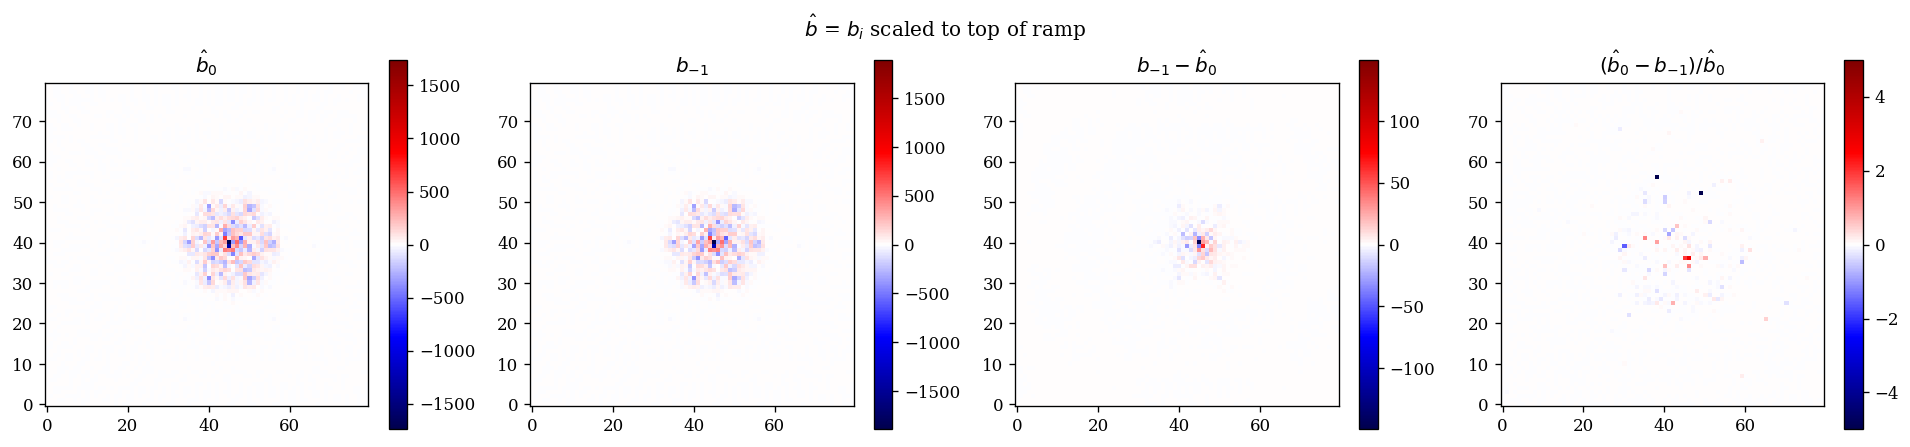

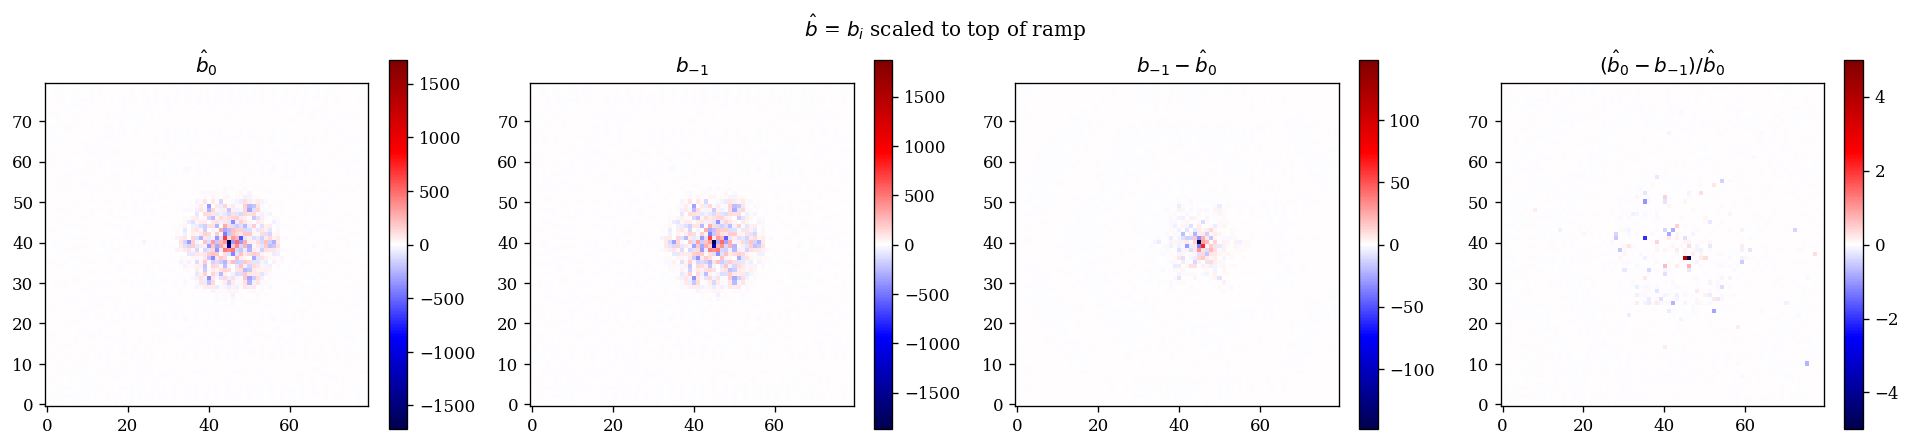

In [13]:
for exp in exposures:
    oversample = final_model.optics.oversample
    ramp = model_fn(final_model, exp, to_BFE=True)
    ngroups = len(ramp)
    fluxes = (np.arange(ngroups) + 1) / ngroups

    ramp0 = ramp[0]
    ramp1 = ramp[-1]

    psf0 = dlu.downsample(ramp0, oversample, mean=False)
    final0 = final_model.BFE.apply_array(ramp0)
    bleeding0 = final0 - psf0

    psf1 = dlu.downsample(ramp1, oversample, mean=False)
    final1 = final_model.BFE.apply_array(ramp1)
    bleeding1 = final1 - psf1

    ramp_vals = (np.arange(ngroups) + 1) / ngroups
    inv_ramp = 1 / ramp_vals

    inv_ramp0 = inv_ramp[0]
    inv_ramp1 = inv_ramp[-1]

    bleed0_norm = bleeding0 * inv_ramp0
    bleed1_norm = bleeding1 * inv_ramp1

    plt.figure(figsize=(20, 4))
    plt.suptitle("$\\hat{b}$ = $b_{i}$ scaled to top of ramp")
    plt.subplot(1, 4, 1)
    plt.title("$\\hat{b}_0$")
    v = np.nanmax(np.abs(bleed0_norm))
    plt.imshow(bleed0_norm, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("$b_{-1}$")
    v = np.nanmax(np.abs(bleed1_norm))
    plt.imshow(bleed1_norm, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("$b_{-1} - \\hat{b}_0$")

    res = bleed1_norm - bleed0_norm
    v = np.nanmax(np.abs(res))
    plt.imshow(res, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("$(\\hat{b}_0 - b_{-1}) / \\hat{b}_0$")
    res_norm = res / bleed0_norm
    v = np.minimum(np.nanmax(np.abs(res_norm)), 5)
    plt.imshow(res_norm, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.show()